In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import seaborn as sns

import os

from PlottingScripts import CV, Spline, Tune1, distVar, distplot_wratio, StackedHisto, SimpleHisto, mcplot

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Welcome to JupyROOT 6.18/04


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad

def PmuGivenX(mu,x):
   
    pi  = np.pi
    c   = [1.,-1./12,1./288,139./51840,-571./2488320,-163879./209018880]
    
    if x == 0:
        return np.exp(-mu)
    else:
        poly = sum(c[i]/x**(i+0.5) for i in range(len(c)))
        return 1/np.sqrt(2*pi)*np.exp(x+x*np.log(mu/x)-mu)*poly
    

    
def GetErrors(xobs,stack,weights,CL=0.6827,fast=True):
       
    step    = 0.5 if fast else 0.05
    ratStep = 0.05 if fast else 0.005

    upperBoundary = int(max(max(stack)+10*np.sqrt(max(stack)),20,xobs+10*np.sqrt(xobs)))
    r = np.arange(0,upperBoundary,step)    
    
    # ---------------------------------------------#
    # Get PDF and confidence limits for xobs
    s    = PmuGivenX(r,xobs)*step
    PDF1 = interp1d(r,s,bounds_error=False,fill_value=0)
    PPF1 = interp1d(np.cumsum(s),r)
    
    xobs_low  = float(PPF1((1-CL)/2))
    xobs_high = float(PPF1(1-(1-CL)/2))
    # -------------------------------------#

    
    # ---------------------------------------------#
    # Get PDF and confidence limits for prediction
    s    = []
    
    for j in stack:
        s.append(PmuGivenX(r,j)*step)
    
    sw = []
    for w,j in enumerate(s):
        rw = [0]*len(j)*3
        for k,l in enumerate(j):
            rs_idx = int(k*weights[w])
            rw[rs_idx]+=l
        sw.append(rw)
    
    if len(sw) > 1:
        for i in range(len(sw)-1):
            if i == 0:
                z = np.convolve(sw[i],sw[i+1],mode='full')
            else:
                z = np.convolve(z,sw[i+1],mode='full')
    else:
        z = sw[0]
                

    convolvedR = np.arange(0,len(z)*step,step)
    
    PDF2 = interp1d(convolvedR,z,bounds_error=False,fill_value=0)
    PPF2 = interp1d(np.cumsum(z),convolvedR)
    
    
    prediction_low  = float(PPF2((1-CL)/2))
    prediction_high = float(PPF2(1-(1-CL)/2))
    # -------------------------------------#    

    # ---------------------------------------------#
    # Get PDF and confidence limits for ratio
    ratioPDF  = []
    tryRats   = np.arange(0,4,ratStep)    
    
    foundLow   = False
    foundHigh  = False
    runningCDF = 0
    ratio_low  = -1
    ratio_high = -1
    for thisRat in tryRats:
        integral = quad(lambda x: x*PDF1(thisRat*x)*PDF2(x),0.001,upperBoundary)[0]*ratStep/step**2

        ratioPDF.append(integral)
        runningCDF+=integral
        if foundLow == False and runningCDF >= (1-CL)/2:
            foundLow  = True
            ratio_low = thisRat
        if foundHigh == False and runningCDF >= 1-(1-CL)/2: 
            ratio_high = thisRat
            foundHigh  = True
    
    return xobs_low,xobs_high, prediction_low, prediction_high, ratio_low, ratio_high

In [30]:
def GetErrorsData(xobs,CL=0.6827):
    step    = 0.01
    upperBoundary = int(max(10,xobs+5*np.sqrt(xobs)))
    r = np.arange(0.01,upperBoundary,step)
    s    = PmuGivenX(r,xobs)*step
    PDF1 = interp1d(r,s,bounds_error=False,fill_value=0)
    PPF1 = interp1d(np.cumsum(s),r)
    xobs_low  = float(PPF1((1-CL)/2))
    xobs_high = float(PPF1(1-(1-CL)/2))
    return xobs_low,xobs_high


## Set scalings

In [3]:
#wc tagger
NUMU_RUN1_POT = 4.71579e+20
NUMU_LOWE_RUN1_POT = 1.63103516179e+21
NUE_RUN1_POT  = 9.80259e+22
RUN1_POT = 4.403e+19   #  run1
EXTRUN1_POT = (22474918.0) / float ( 9776965.0) * RUN1_POT #run1
DIRT_RUN1_POT = 2.61947e+20

NUMU_RUN3_POT = 8.98773223801e+20
NUMU_LOWE_RUN3_POT = 1.51234621011e+21
NUE_RUN3_POT = 4.70704675581e+22
RUN3_POT = 8.786e+18 # no beam quality  cut
#RUN3_POT = 1.701e+20 #1.5e20
EXTRUN3_POT = (39566274.0) / float (2263559) * RUN3_POT
#EXTRUN3_POT = (39566274.0) / float (43980680.0) * RUN3_POT


POT_SCALE_FACTOR = RUN1_POT
NUMU_RUN1_SCALE = POT_SCALE_FACTOR / float(NUMU_RUN1_POT)
NUMU_LOWE_RUN1_SCALE = POT_SCALE_FACTOR / float(NUMU_LOWE_RUN1_POT)
NUMU_RUN3_SCALE = POT_SCALE_FACTOR / float(NUMU_RUN3_POT)
NUMU_LOWE_RUN3_SCALE = POT_SCALE_FACTOR / float(NUMU_LOWE_RUN3_POT)
NUE_RUN1_SCALE = POT_SCALE_FACTOR / float(NUE_RUN1_POT)
NUE_RUN3_SCALE = POT_SCALE_FACTOR / float(NUE_RUN3_POT)
EXT_RUN1_SCALE = POT_SCALE_FACTOR / float(EXTRUN1_POT)
EXT_RUN3_SCALE = POT_SCALE_FACTOR / float(EXTRUN3_POT)
DIRT_RUN1_SCALE = POT_SCALE_FACTOR / float(DIRT_RUN1_POT)


RUN1_SCALE = POT_SCALE_FACTOR / float(RUN1_POT)
RUN3_SCALE = POT_SCALE_FACTOR / float(RUN3_POT)

print(RUN3_POT)

8.786e+18


## Load up parquets with our samples and apply precuts

In [4]:
tag = 'May1'

orthogonalcut = 'MaxShrFrac < .2'
precuts ='ChargeNearTrunk > 0 and FailedBoost != 1 and OpenAng > .5'# and  and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15'
emptycut = 'Enu_1m1p > 0'

precut = orthogonalcut + ' and ' + precuts

df_numu_run1_presel = pd.read_parquet('../data/pickles/numu_run1_nodupes%s.parquet'%tag).query(precut)
df_numu_run1_presel_lowe = pd.read_parquet('../data/pickles/numu_lowe_run1_nodupes%s.parquet'%tag).query(precut)

df_numu_run3_presel = pd.read_parquet('../data/pickles/numu_run3_nodupes%s.parquet'%tag).query(precut)
df_numu_run3_presel_lowe = pd.read_parquet('../data/pickles/numu_lowe_run3_nodupes%s.parquet'%tag).query(precut)

df_nue_run1_presel = pd.read_parquet('../data/pickles/nue_run1_nodupes%s.parquet'%tag).query(precut)
df_nue_run3_presel = pd.read_parquet('../data/pickles/nue_run3_nodupes%s.parquet'%tag).query(precut)

df_ext_run1_presel = pd.read_parquet('../data/pickles/ext_run1_nodupes%s.parquet'%tag).query(precut)
df_ext_run3_presel = pd.read_parquet('../data/pickles/ext_run3_nodupes%s.parquet'%tag).query(precut)

df_data_run1_presel = pd.read_parquet('../data/pickles/data_run1_nodupes%s.parquet'%tag).query(precut)
df_data_run3_presel = pd.read_parquet('../data/pickles/data_run3_nodupes%s.parquet'%tag).query(precut)

#df_data_run3_presel = pd.read_parquet('../data/pickles/data_run3_filter_nodupes%s.parquet'%tag).query(precut)

df_dirt_run1_presel = pd.read_parquet('../data/pickles/dirt_run1_nodupes%s.parquet'%tag).query(precut)

In [5]:
alldfs = [df_numu_run1_presel,df_numu_run1_presel_lowe,df_numu_run3_presel,df_numu_run3_presel_lowe,df_nue_run1_presel,df_nue_run3_presel,df_ext_run1_presel,df_ext_run3_presel,df_data_run1_presel,df_data_run3_presel,df_dirt_run1_presel]

In [6]:
#add experimental weights

with open('/home/dcianci/Physics/1e1p/1mu1pSelection/bdtweights_1m1p_run1_lowe_may13vars.pickle','rb') as handle: bdt_run1_cosmic,bdt_run1_nu = pickle.load(handle)          # Load BDT weights for 1mu1p background differentiation
with open('/home/dcianci/Physics/1e1p/1mu1pSelection/bdtweights_1m1p_run3_lowe_may13vars.pickle','rb') as handle: bdt_run3_cosmic,bdt_run3_nu = pickle.load(handle)          # Load BDT weights for 1mu1p background differentiation
  
vars_may13 = ['OpenAng','Phis','ChargeNearTrunk','Enu_1m1p','PhiT_1m1p','AlphaT_1m1p','PT_1m1p','PTRat_1m1p','BjX_1m1p','BjY_1m1p','Sph_1m1p','Q0_1m1p','Q3_1m1p','Lepton_PhiReco','Lepton_TrackLength','Proton_PhiReco','Proton_ThetaReco']
myvars = vars_may13

In [7]:
for df in alldfs:
    df.insert(0,'bdt_run1_cosmic',bdt_run1_cosmic.predict_proba(df[myvars].values.tolist())[:,0])
    df.insert(0,'bdt_run1_nu',bdt_run1_nu.predict_proba(df[myvars].values.tolist())[:,0])
    df.insert(0,'bdt_run3_cosmic',bdt_run3_cosmic.predict_proba(df[myvars].values.tolist())[:,0])
    df.insert(0,'bdt_run3_nu',bdt_run3_nu.predict_proba(df[myvars].values.tolist())[:,0])
    
    df.insert(0,'Lepton_CosTheta',np.cos(df['Lepton_ThetaReco'].values).tolist())
    df.insert(0,'Proton_CosTheta',np.cos(df['Proton_ThetaReco'].values).tolist())
    
    print('one down')


one down
one down
one down
one down
one down
one down
one down
one down
one down
one down
one down


In [29]:
len(df_numu_run3_presel.query(s_cuts))

2883

## Define our histogram stacks

In [8]:
run1Hists = StackedHisto((df_numu_run1_presel.query('MC_energyInit > 400'),df_numu_run1_presel_lowe,df_nue_run1_presel),(NUMU_RUN1_SCALE,NUMU_LOWE_RUN1_SCALE,NUE_RUN1_SCALE))
#run1Hists = StackedHisto((df_numu_run1_presel,df_nue_run1_presel),(NUMU_RUN1_SCALE,NUE_RUN1_SCALE))
run1Hists.AddStrata("mc_label in ['numu_CCQE']",r'BNB $\nu_\mu$ CCQE','blue')
run1Hists.AddStrata("mc_label in ['numu_MEC']",r'BNB $\nu_\mu$ MEC','cyan')
run1Hists.AddStrata("mc_label in ['numu_piplusminus']",r'BNB $\nu_\mu$ Res $\pi^{+/-}$','darkgreen')
run1Hists.AddStrata("mc_label in ['numu_pizero']",r'BNB $\nu_\mu$ Res $\pi^{0}$','greenyellow')
run1Hists.AddStrata("mc_label in ['nue_CCQE']",r'$\nu_e$ Intrinsic','pink')
run1Hists.AddStrata("mc_label in ['numu_other','BNB nue_other','nue_MEC','nue_piplusminus','nue_pizero']",r'BNB Other','gold')
run1Hists.AddStrata("mc_label in ['badreco']",r'BNB Bad Reco','coral')
run1Hists.AddStrata("mc_label in ['offvtx']",r'BNB 1L1P Off Vertex','grey')
run1Hists.AddStrata("mc_label in ['nLmP']",r'BNB Not 1L1P','crimson')
run1Hists.AddLayer(df_dirt_run1_presel,DIRT_RUN1_SCALE,1,'Dirt','peru')
run1Hists.AddLayer(df_ext_run1_presel,EXT_RUN1_SCALE,0,'Cosmic Background','fuchsia')

run1DataHist = SimpleHisto(df_data_run1_presel,RUN1_SCALE,0,'','bnb5e19 [Run 1]')
#fakeDataHist = SimpleHisto(df_fakedata_presel,1,0,'','Fakedata')


run3Hists = StackedHisto((df_numu_run3_presel.query('MC_energyInit > 400'),df_numu_run3_presel_lowe,df_nue_run3_presel),(NUMU_RUN3_SCALE,NUMU_LOWE_RUN3_SCALE,NUE_RUN3_SCALE))
run3Hists.AddStrata("mc_label in ['numu_CCQE']",r'BNB $\nu_\mu$ CCQE','blue')
run3Hists.AddStrata("mc_label in ['numu_MEC']",r'BNB $\nu_\mu$ MEC','cyan')
run3Hists.AddStrata("mc_label in ['numu_piplusminus']",r'BNB $\nu_\mu$ Res $\pi^{+/-}$','darkgreen')
run3Hists.AddStrata("mc_label in ['numu_pizero']",r'BNB $\nu_\mu$ Res $\pi^{0}$','greenyellow')
run3Hists.AddStrata("mc_label in ['nue_CCQE']",r'$\nu_e$ Intrinsic','pink')
run3Hists.AddStrata("mc_label in ['numu_other','BNB nue_other','nue_MEC','nue_piplusminus','nue_pizero']",r'BNB Other','gold')
run3Hists.AddStrata("mc_label in ['badreco']",r'BNB Bad Reco','coral')
run3Hists.AddStrata("mc_label in ['offvtx']",r'BNB 1L1P Off Vertex','grey')
run3Hists.AddStrata("mc_label in ['nLmP']",r'BNB Not 1L1P','crimson')
run3Hists.AddLayer(df_dirt_run1_presel,DIRT_RUN1_SCALE,1,'Dirt','peru')
run3Hists.AddLayer(df_ext_run3_presel,EXT_RUN3_SCALE,0,'Cosmic Background','fuchsia')
#run3Hists.AddLayer(df_numu_run1_presel_lowe,NUMU_LOWE_RUN3_SCALE,1,'Low E Patch','deepskyblue')

run3DataHist = SimpleHisto(df_data_run3_presel,RUN3_SCALE,0,'','bnb1e19 [Run 3]')

# Apply cuts

In [203]:
#bdtcuts = 'BDTscore_1mu1p_cosmic > 0 and BDTscore_1mu1p_nu > 0'
#bdtcuts = 'abs(bdt_score_cosmic_13-bdt_score_nu_13) < .05'
bdtcuts = 'bdt_run1_cosmic < .5 and bdt_run1_nu < .5'

emptycut = 'Enu_1m1p > 0'
morecuts = 'Enu_1m1p < 1000'#Lepton_CosTheta < .9'

s_cuts = bdtcuts + ' and ' + morecuts

s_ano_simple_w = wrap('Precuts and '+s_cuts,28)
s_ano_simple = '' 
for ln in s_ano_simple_w:
    s_ano_simple += ln + '\n'

In [204]:
run1Hists.AddCut(s_cuts)
run3Hists.AddCut(s_cuts)
run1DataHist.AddCut(s_cuts)
run3DataHist.AddCut(s_cuts)

In [205]:
#Define all important things

myvar = 'Enu_1m1p'   #variable in df
varname = vartest    #label for x axis
myrange = (300,1200)
legpos = 0
nbins = 18

stackedhists = run3Hists
datahist = run1DataHist


s_cov_sys = '../data/CovMatrices_May19_gevcut/covar_gevcut__nu_energy_reco.txt'
s_cov_detsys = 'detsys_%s_cov.csv'%myvar

m_cov_sys = np.genfromtxt(s_cov_sys,delimiter=',')
m_cov_detsys = np.genfromtxt(s_cov_detsys,delimiter=',')
m_cov = m_cov_detsys+m_cov_sys

In [206]:
vals_mc = np.zeros(nbins)
vals_mc_raw = np.zeros(nbins)
yerrsq_mc = np.zeros(nbins)
yrr_mc_sys = np.zeros(nbins)
ndof = 0

a_labels_evts = []

gh_vals,gh_cols,gh_labels,gh_wgts,gh_scale = stackedhists.GetHists(myvar)
data_vals,_,data_label,data_wgt,data_scale = datahist.GetHist(myvar)

In [207]:
# for poisson error bars:
a_hstack = []
a_hscale = []
    
for i in range(len(gh_vals)):
    h1_raw,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i])     # hist of raw event weights
    h1,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i]*gh_scale[i])

    vals_mc_raw += h1_raw
    vals_mc += h1
    
    scalesort = gh_scale[i].argsort()
    sorted_vals = gh_vals[i][scalesort[::-1]]
    sorted_scale = gh_scale[i][scalesort[::-1]]
    sorted_wgt = gh_wgts[i][scalesort[::-1]]
    for sc in np.unique(sorted_scale):
        subvals = sorted_vals[sorted_scale==sc]
        subwgts = sorted_wgt[sorted_scale==sc]
        subh1,_ = np.histogram(subvals,nbins,range=myrange,weights=subwgts)
        yerrsq_mc += np.power(np.sqrt(subh1)*sc,2)
        a_hstack.append(subh1)
        a_hscale.append(sc)
        
    a_labels_evts.append(gh_labels[i]+' (%.2f)'%h1.sum())

vals_data_raw,binedges = np.histogram(data_vals,nbins,range=myrange,weights=data_wgt)
vals_data,_ = np.histogram(data_vals,nbins,range=myrange,weights=np.multiply(data_wgt,data_scale))
bincenters = np.diff(binedges)/2 + binedges[:-1]    

In [208]:
#jarretbars
a_obslo = []
a_obshi = []
for i in range(nbins):
    obslo,obshi = GetErrorsData(vals_data[i])
    a_obshi.append(obshi-vals_data[i])
    a_obslo.append(vals_data[i]-obslo)

In [209]:
yerr_mc_sys  = np.sqrt(np.diag(m_cov))
yerr_mc_total = np.sqrt(np.diag(m_cov) + yerrsq_mc)


In [210]:
yerrsq_data = np.zeros(nbins)
for i in range(nbins):
    if vals_mc_raw[i] > 0:
        ndof += 1
        if vals_data[i] > 0:
            yerrsq_data[i] += (3.0*vals_data[i]*vals_mc[i])/(vals_mc[i]+2.0*vals_data[i])
        else:
            yerrsq_data[i] += vals_mc[i]/2.0
        m_cov[i][i] += yerrsq_data[i]
    else:
        m_cov[i][i] += 999

yerr_data = np.sqrt(yerrsq_data)

In [224]:
er_rat_line = np.zeros(nbins)
er_rat_line_sys = np.zeros(nbins)
er_rat_dotshi = np.zeros(nbins)
er_rat_dotslo = np.zeros(nbins)

for i in range(nbins):
    if vals_mc[i] > 0:
        er_rat_line[i] = yerr_mc_total[i]/float(vals_mc[i])
        er_rat_line_sys[i] = yerr_mc_sys[i]/float(vals_mc[i])
        er_rat_dotshi[i] = a_obshi[i]/float(vals_mc[i])
        er_rat_dotslo[i] = a_obslo[i]/float(vals_mc[i])
        

In [225]:
chisq = 0.0
invcov = np.linalg.inv(m_cov)
# calc chi2
for i in range(nbins):
    for j in range(nbins):
        if vals_mc_raw[i] > 0 and vals_mc_raw[j] > 0:
            chisq += (vals_mc[i] - vals_data[i]) * (vals_mc[j] - vals_data[j]) * invcov[i][j]
pval = 1 - stats.chi2.cdf(chisq, ndof)

print(chisq/float(ndof),pval)

0.5046571200184287 0.9321692385324396


/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


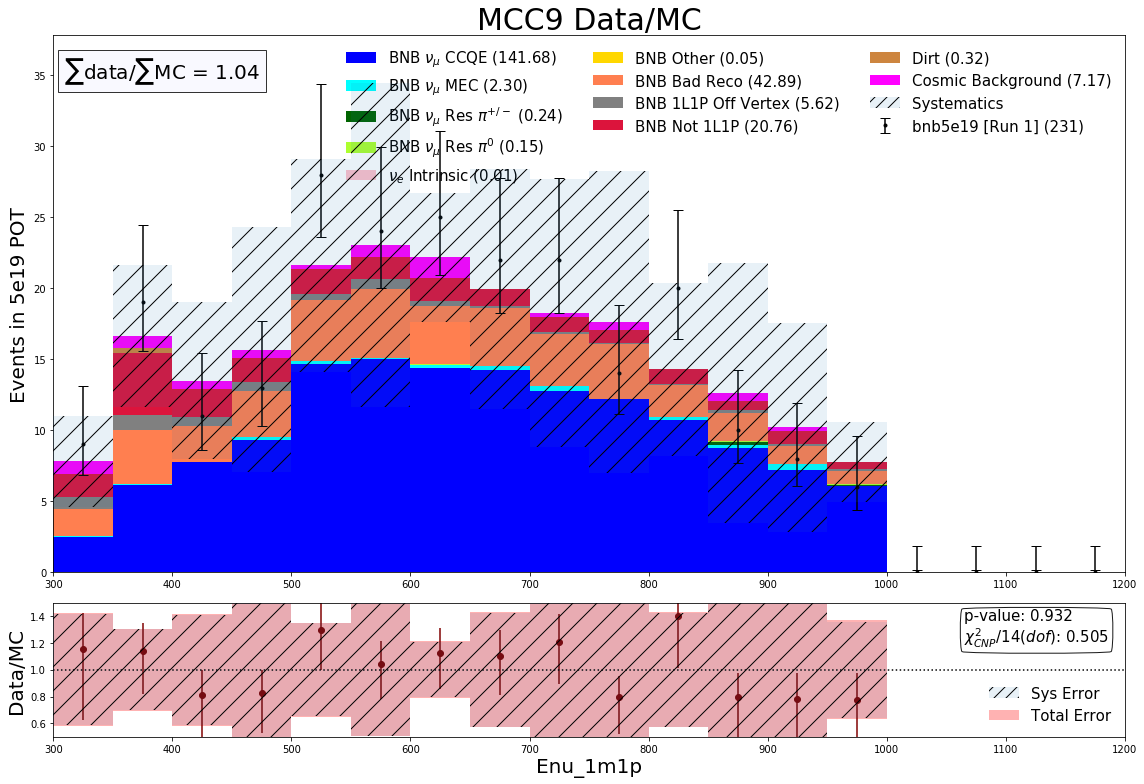

In [226]:
fig,ax = plt.subplots(figsize=(16,11))
fig.patch.set_alpha(1)
   
    
gs = gridspec.GridSpec(2, 1, height_ratios=[3, .75])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ymax = max(vals_data.max(),vals_mc.max())*1.35

ax0.set_ylim(0,ymax)
ax0.set_xlim(myrange)
ax1.set_ylim(.5,1.5)
ax1.set_xlim(myrange)
ax1.set_xlabel(varname,fontsize=20)
ax0.set_ylabel('Events in 5e19 POT',fontsize=20)
ax1.set_ylabel('Data/MC',fontsize=20)
ax0.set_title('MCC9 Data/MC',fontsize=30)

ax0.hist(gh_vals,nbins,range=myrange,weights=[gh_wgts[i]*gh_scale[i] for i in range(len(gh_wgts))],color=gh_cols,stacked=True,linewidth=0,label=a_labels_evts,edgecolor=None)
ax0.errorbar(bincenters,vals_data,fmt='.',yerr=(a_obslo,a_obshi),color='black',capsize=5,label=data_label+' (%i)'%vals_data.sum())

errboxes = []
for i in range(len(bincenters)):
    rect = Rectangle((binedges[i],(vals_mc[i]-yerr_mc_sys[i])),binedges[i+1]-binedges[i],yerr_mc_sys[i]*2)
    errboxes.append(rect)
pc = PatchCollection(errboxes,facecolor=None,alpha=.1,hatch='/',zorder=12)
ax0.add_collection(pc)
ax0.hist(np.zeros(1),(1,2),facecolor=None,alpha=.1,hatch='//',zorder=0,label='Systematics')
ax0.legend(loc='upper right',fontsize=15,frameon=False,ncol=3)


errboxes_tot = []
errboxes_sys = []
for i in range(len(er_rat_dotshi)):
    #    if 
    rect_tot = Rectangle((binedges[i],1-er_rat_line[i]),binedges[i+1]-binedges[i],er_rat_line[i]*2)
    errboxes_tot.append(rect_tot)
    rect_sys = Rectangle((binedges[i],1-er_rat_line_sys[i]),binedges[i+1]-binedges[i],er_rat_line_sys[i]*2)
    errboxes_sys.append(rect_sys)

pc_tot = PatchCollection(errboxes_tot, facecolor='red', alpha=.3)
pc_sys = PatchCollection(errboxes_sys, facecolor=None, alpha=.1,hatch='/',zorder=12)
ax1.add_collection(pc_tot)
ax1.add_collection(pc_sys)
ax1.hist(np.zeros(1),(1,2),facecolor=None,alpha=.1,hatch='//',zorder=0,label='Sys Error')
   
ax1.hist(np.zeros(1),(1,2),facecolor='red',alpha=.3,zorder=0,label='Total Error')
ax1.errorbar(bincenters,np.true_divide(vals_data,vals_mc),yerr=(er_rat_dotshi,er_rat_dotslo),fmt='o',color='maroon',capsize=0)

ax1.legend(loc='lower right',fontsize=15,frameon=False)


ax1.axhline(1,color='black',linestyle=':')
ax0.annotate(r'$\sum$data/$\sum$MC = %.2f'%(vals_data.sum()/float(vals_mc.sum())),xy=(.01,.92),xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))

ax1.annotate('p-value: %.3f\n'%pval+r'$\chi^2_{CNP}/%i  (dof)$: %.3f'%(ndof,chisq/float(ndof)),xy=(.85,.7), xycoords='axes fraction',fontsize=15,bbox=dict(boxstyle="round4", fc="w",alpha=.9))

plt.tight_layout()
   

Events: 171.0
Min Bin ct (data): 5.0


Text(120.25, 0.5, 'Events in 1.5e20 POT')

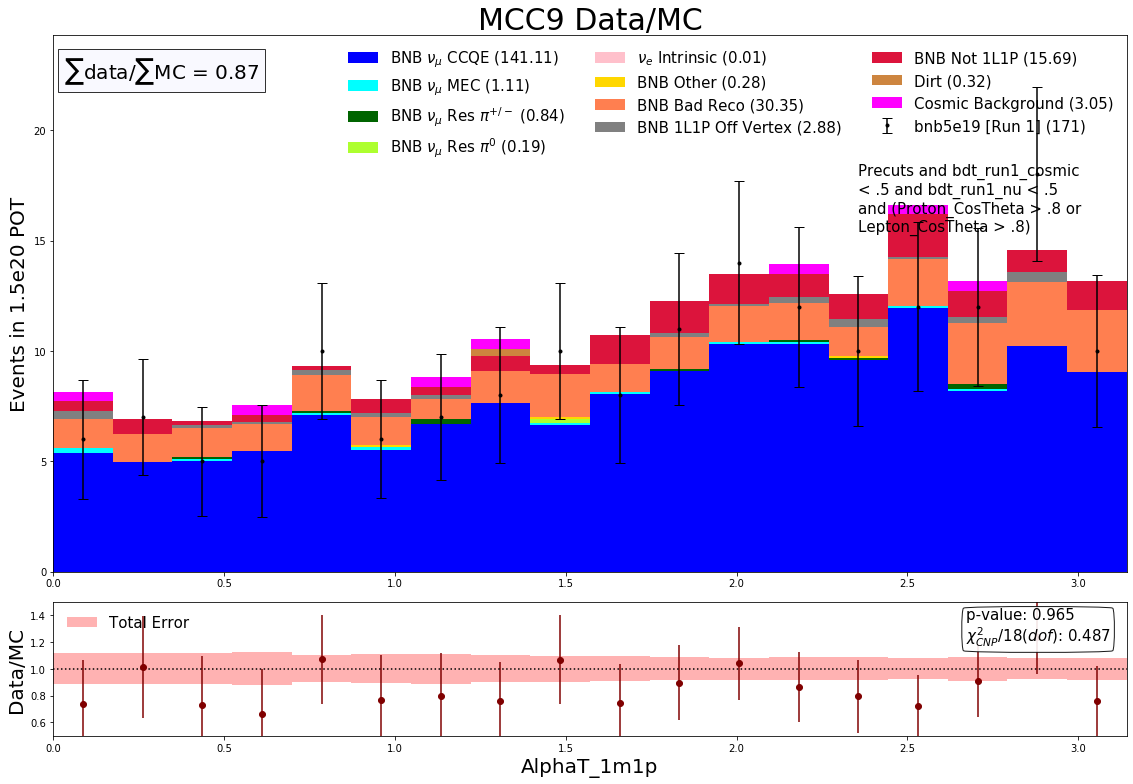

In [122]:
vartest = 'AlphaT_1m1p'
varname = vartest
myrange = (0,np.pi)
legpos = 0

fig,ax0,_ = distplot_wratio(vartest,nbins,myrange,run1Hists,run1DataHist,varname)
ax0.annotate(s_ano_simple,xy=(.75,.6), xycoords='axes fraction',fontsize=15)
ax0.set_ylabel('Events in 1.5e20 POT',fontsize=20)

Events: 161.0
Min Bin ct (data): 1.0
Events: 165.0
Min Bin ct (data): 4.0
Events: 168.0
Min Bin ct (data): 2.0
Events: 171.0
Min Bin ct (data): 0.0
Events: 171.0
Min Bin ct (data): 0.0
Events: 171.0
Min Bin ct (data): 0.0
Events: 171.0
Min Bin ct (data): 0.0
Events: 161.0
Min Bin ct (data): 2.0
Events: 167.0
Min Bin ct (data): 0.0
Events: 171.0
Min Bin ct (data): 5.0
Events: 171.0
Min Bin ct (data): 0.0
Events: 167.0
Min Bin ct (data): 2.0
Events: 171.0
Min Bin ct (data): 0.0
Events: 171.0
Min Bin ct (data): 0.0
Events: 147.0
Min Bin ct (data): 0.0
Events: 146.0
Min Bin ct (data): 0.0
Events: 169.0
Min Bin ct (data): 0.0
Events: 167.0
Min Bin ct (data): 1.0
Events: 160.0
Min Bin ct (data): 0.0
Events: 171.0
Min Bin ct (data): 1.0
Events: 171.0
Min Bin ct (data): 0.0
Events: 120.0
Min Bin ct (data): 0.0
Events: 139.0
Min Bin ct (data): 0.0
Events: 171.0
Min Bin ct (data): 2.0
Events: 171.0
Min Bin ct (data): 0.0
Events: 142.0
Min Bin ct (data): 0.0
Events: 162.0
Min Bin ct (data): 0.0
E

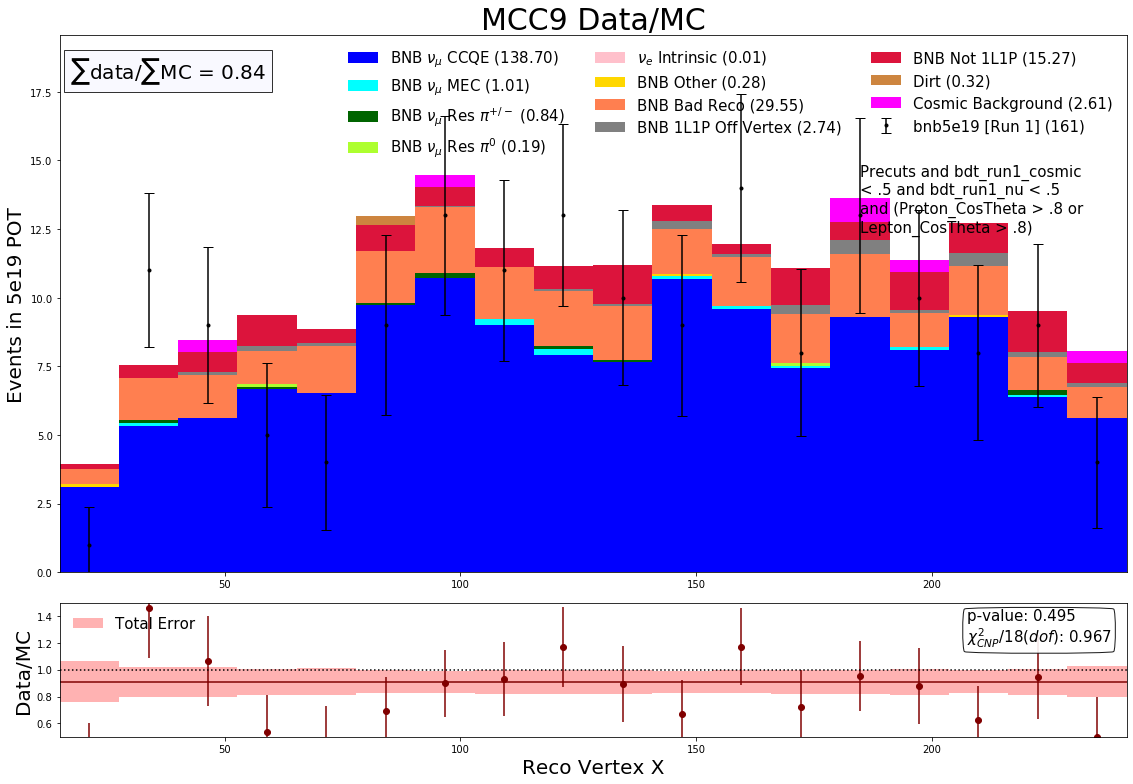

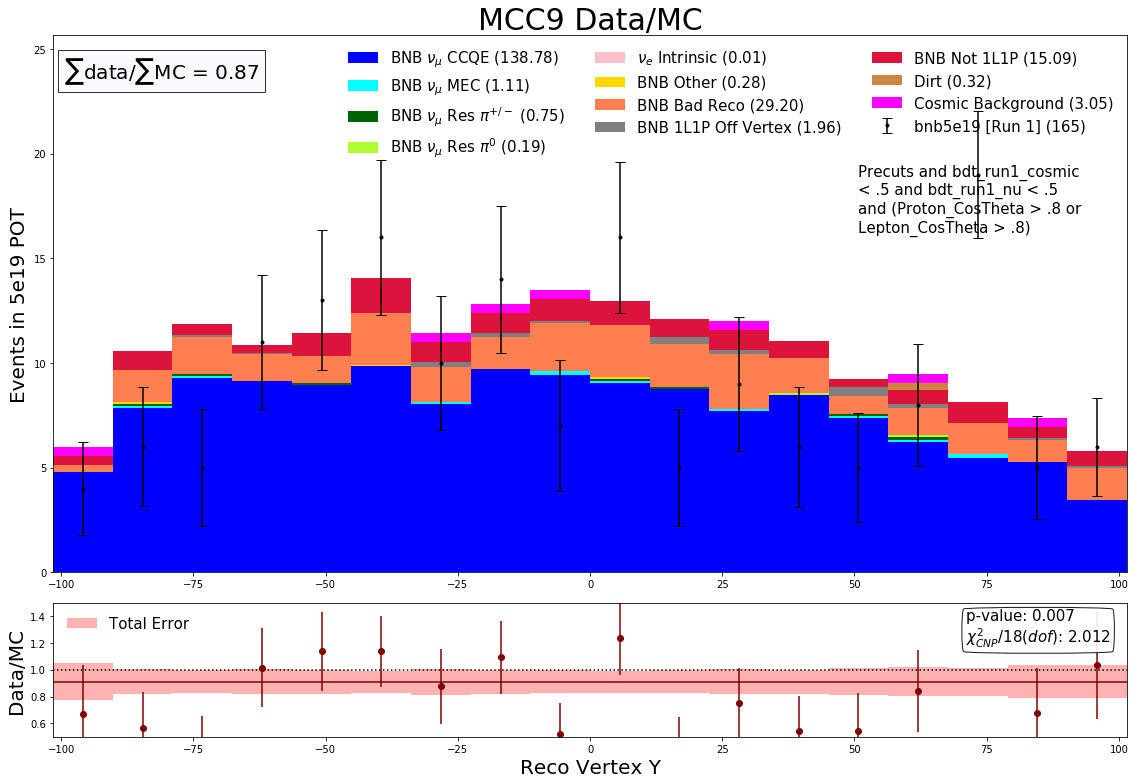

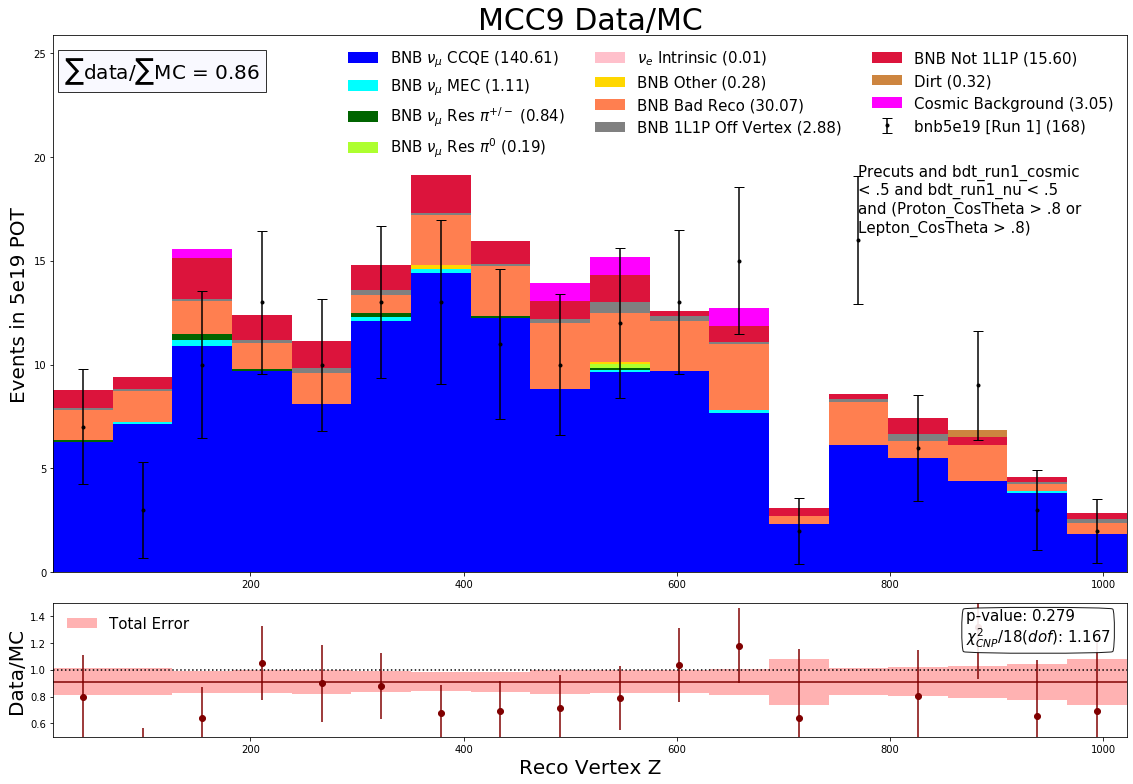

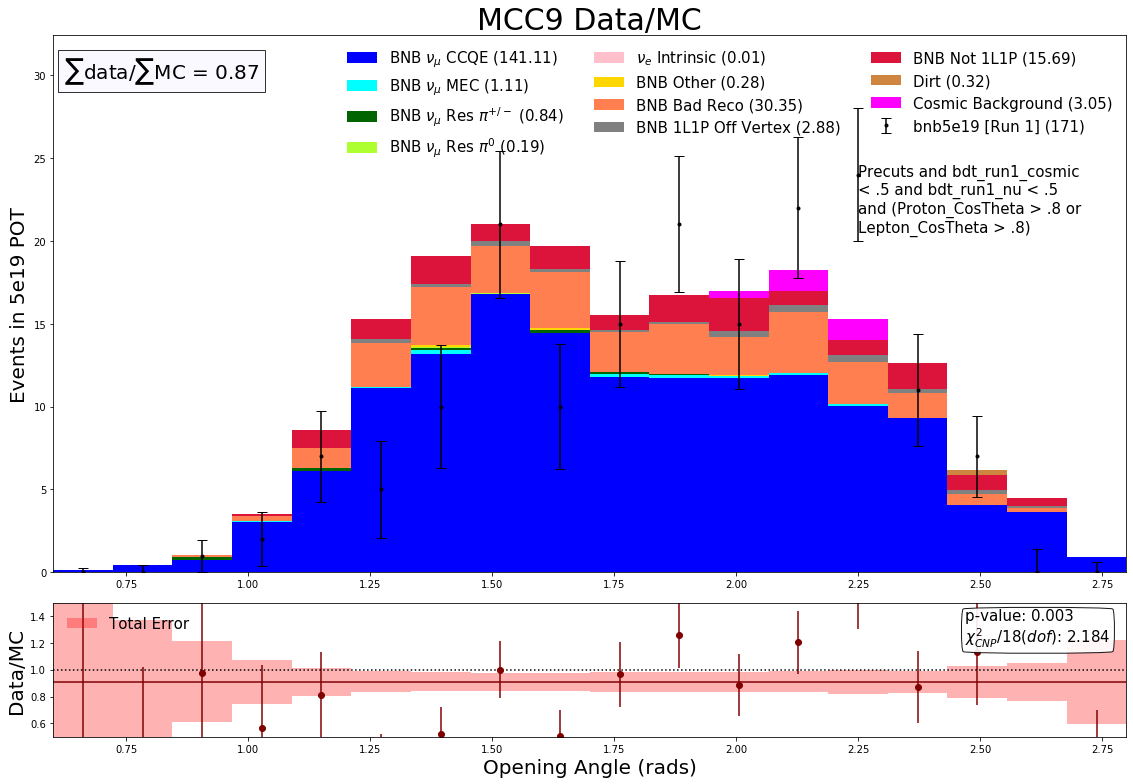

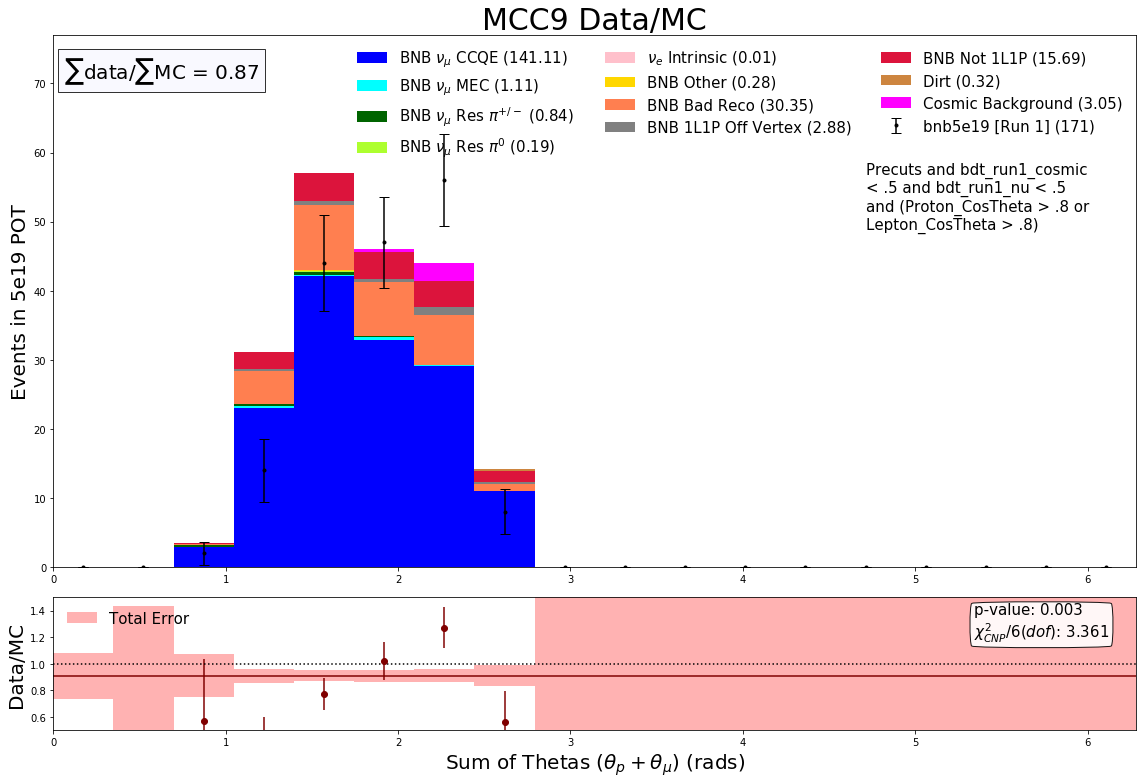

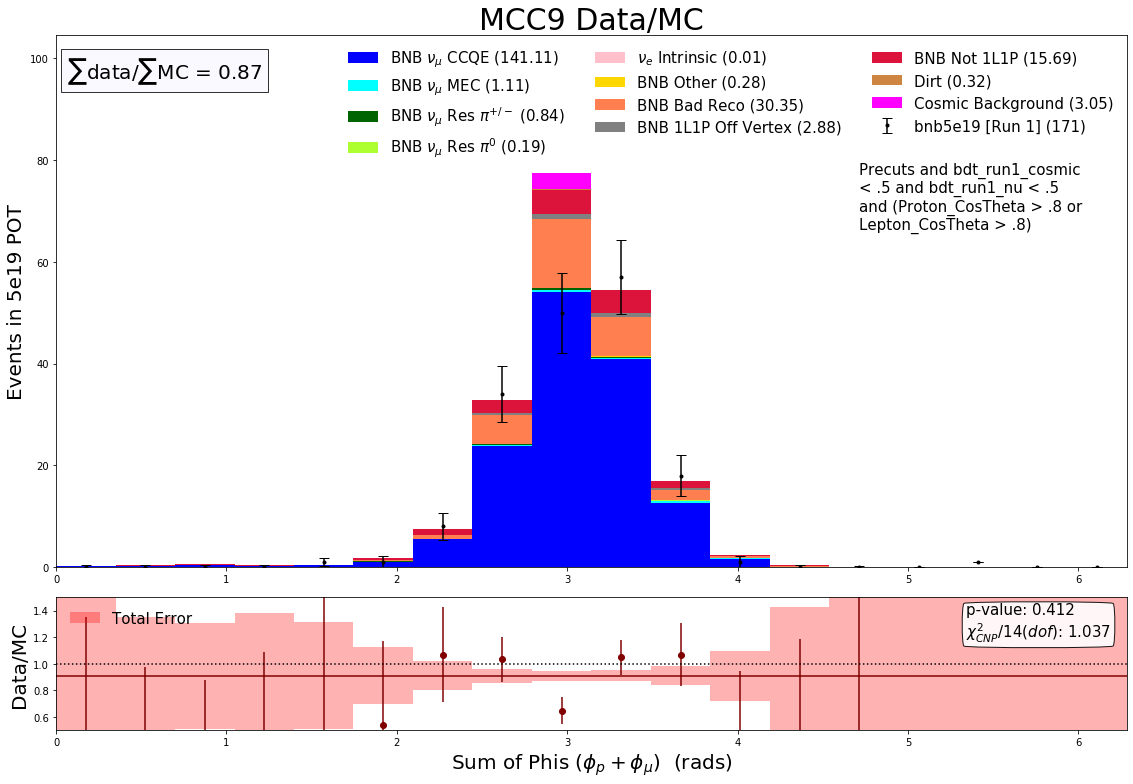

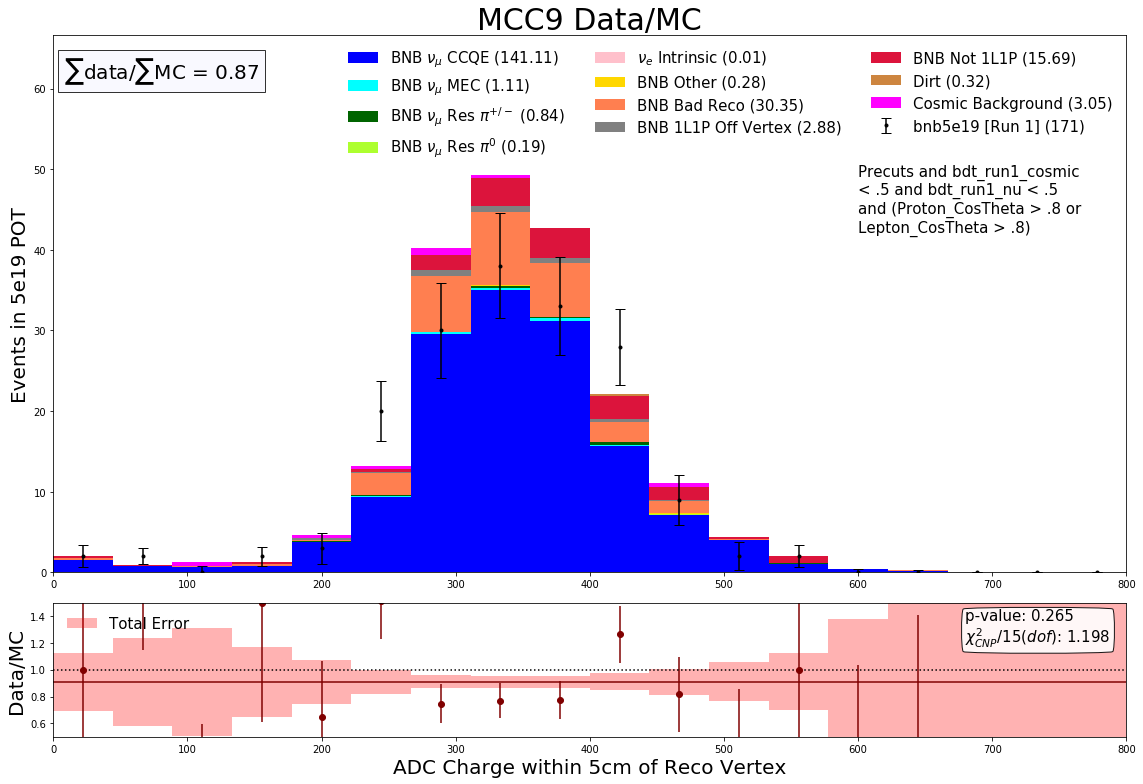

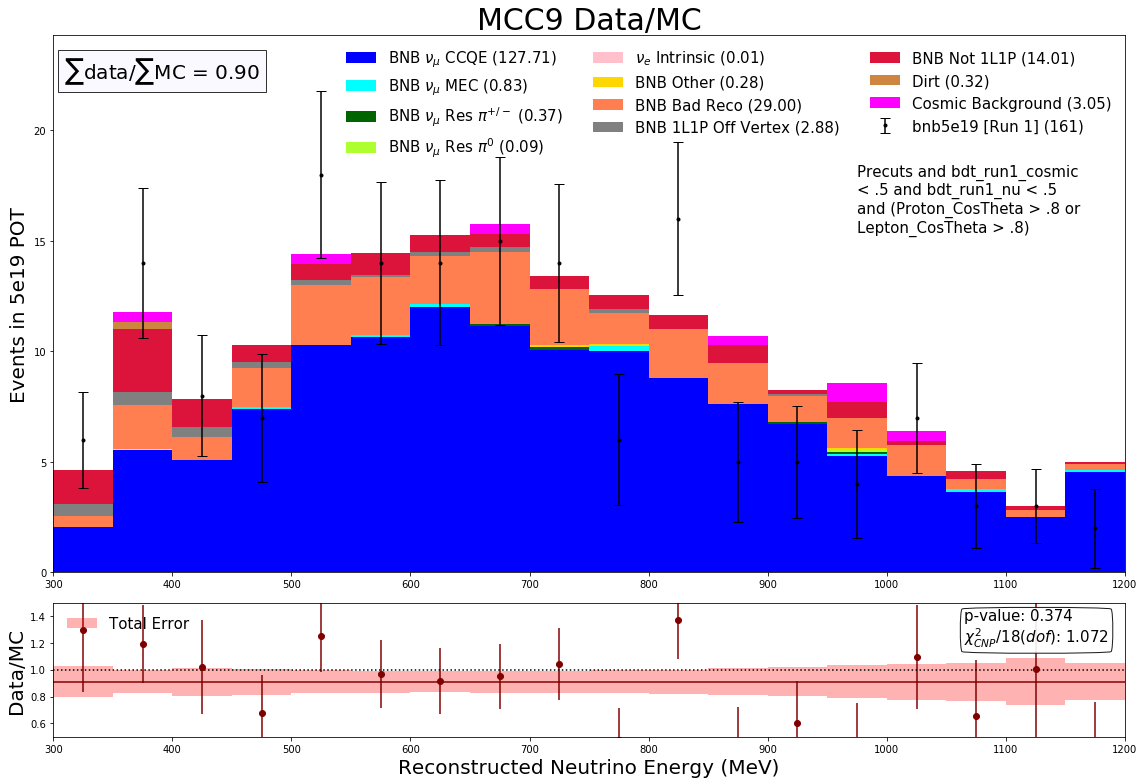

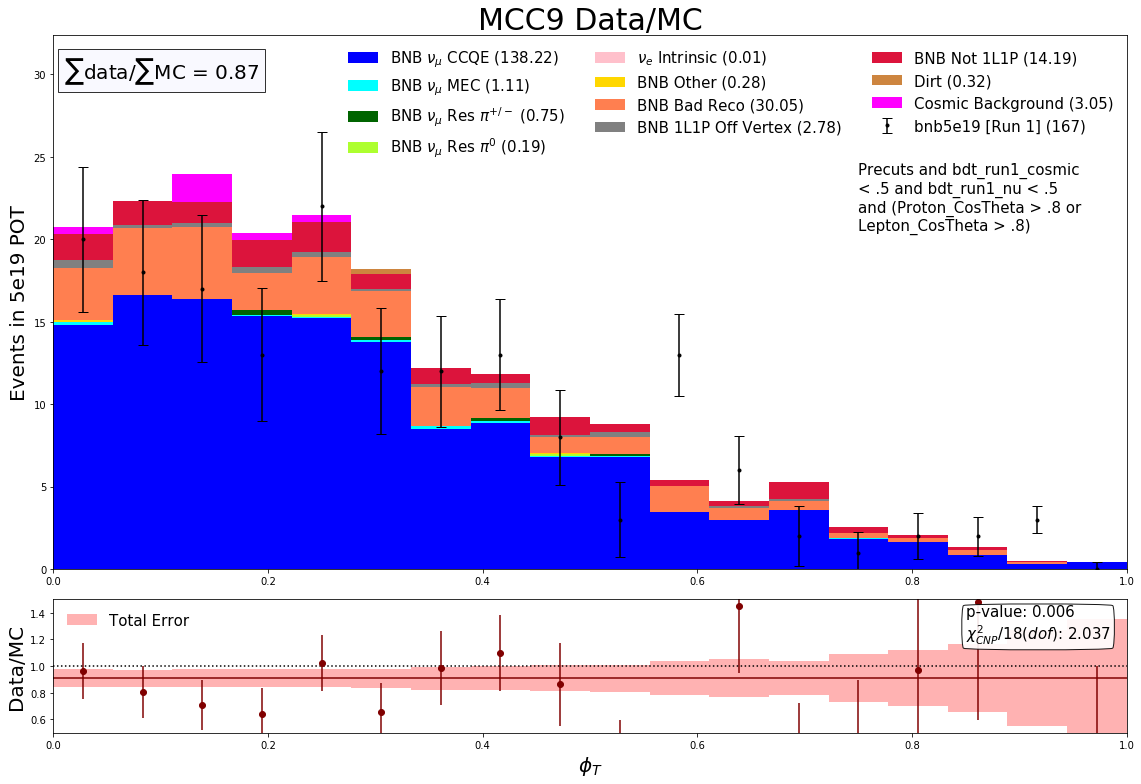

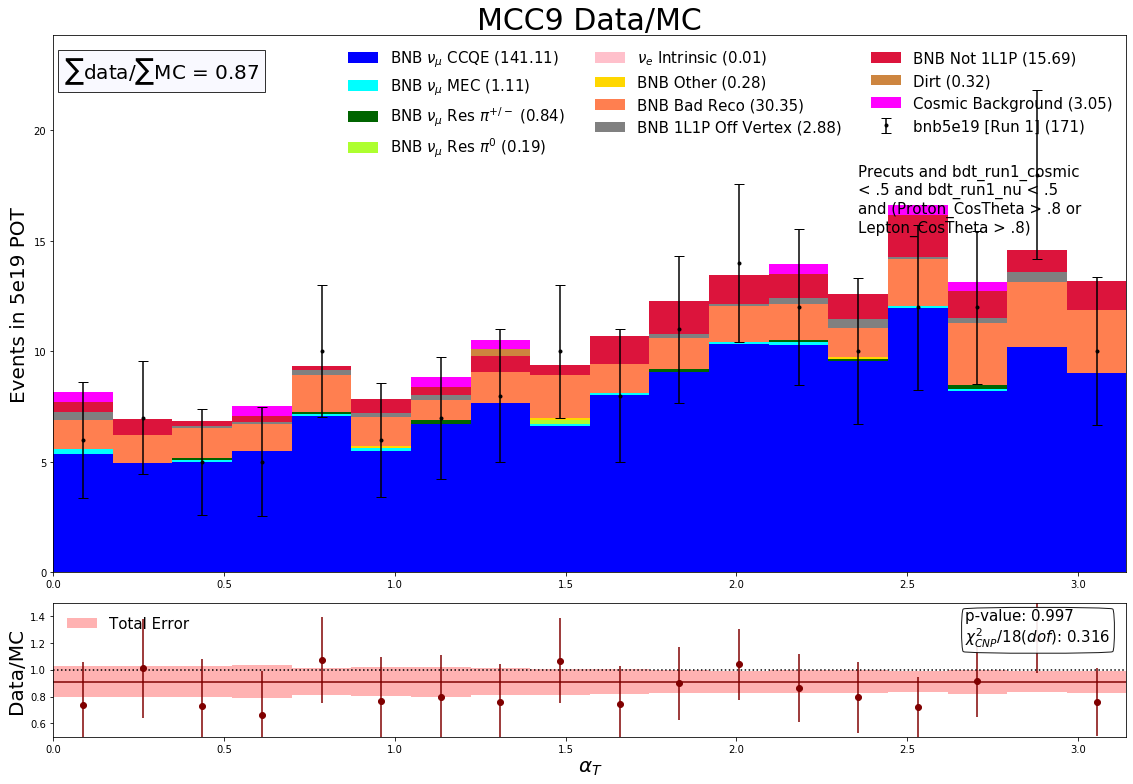

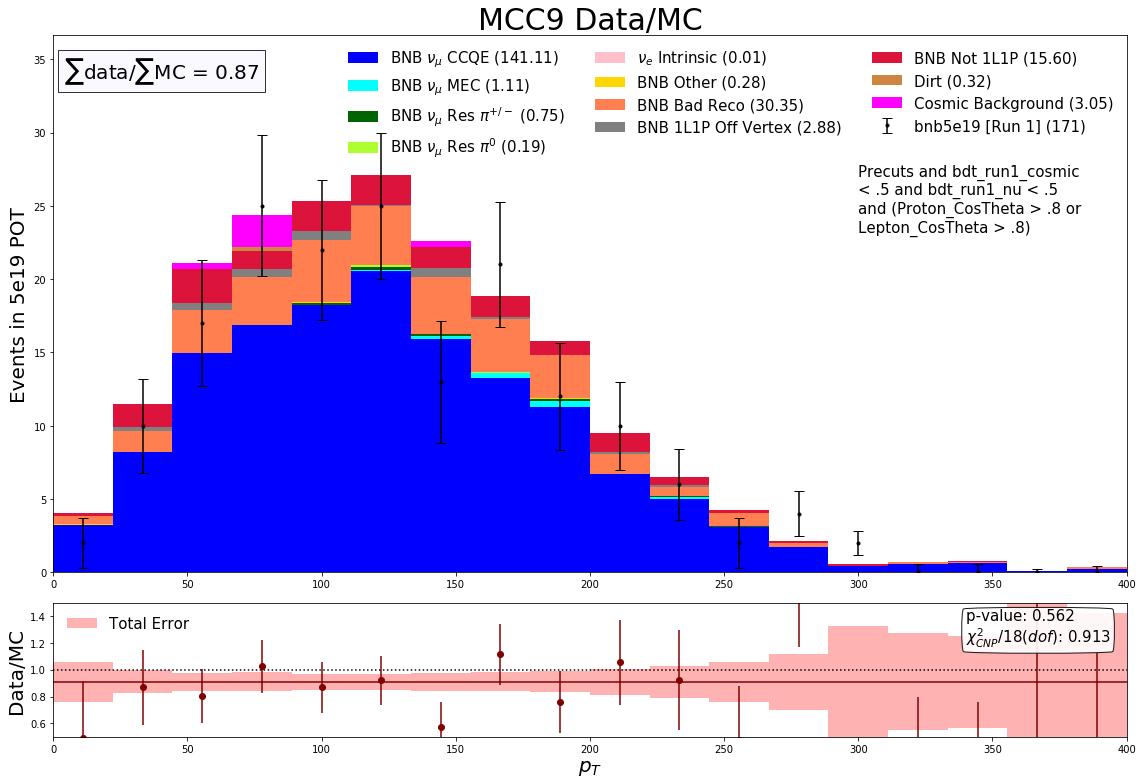

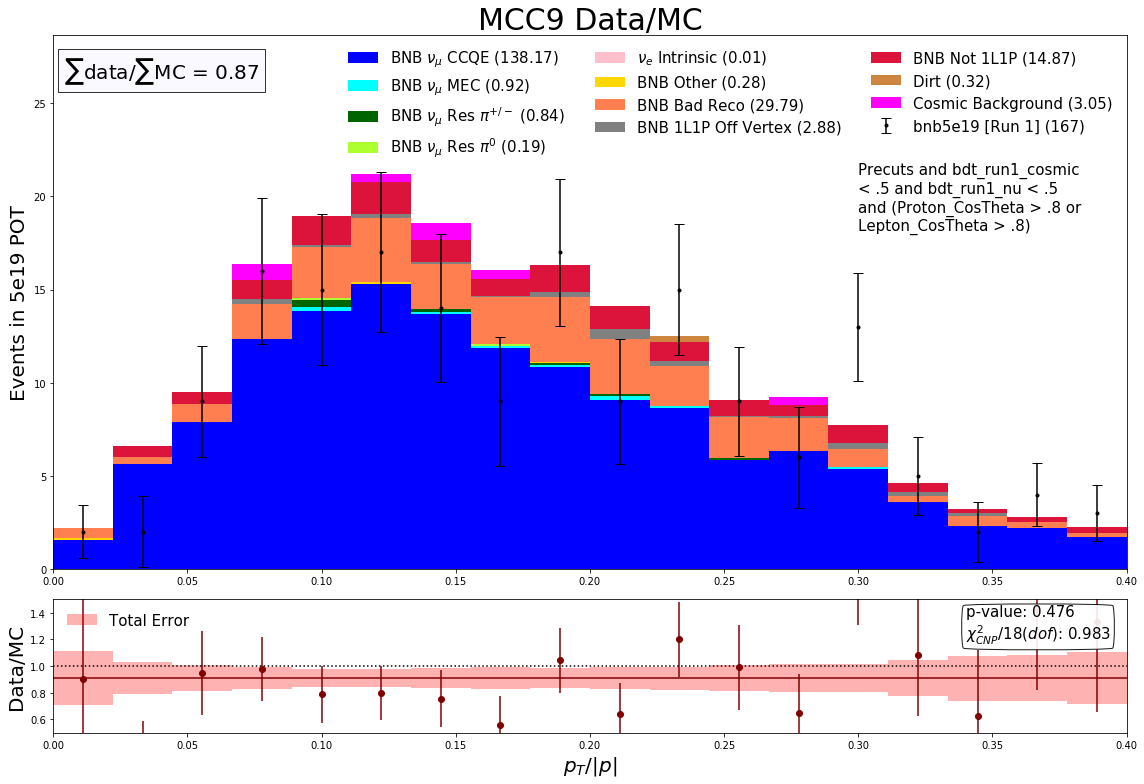

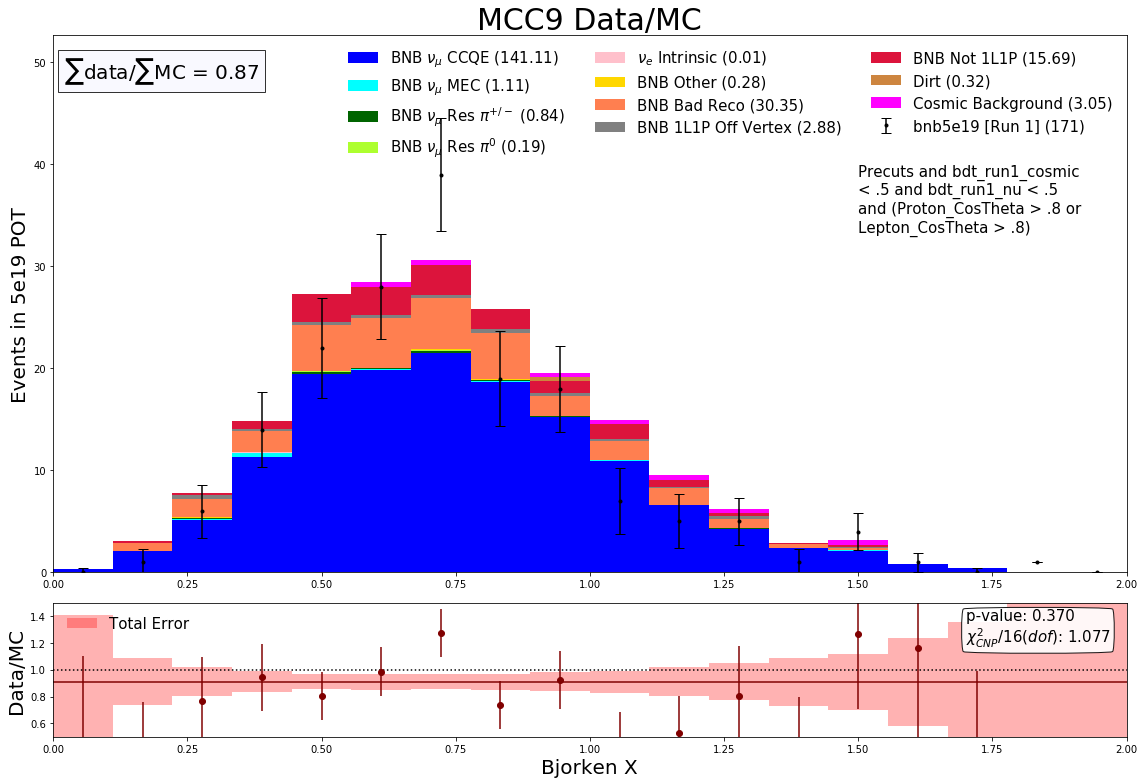

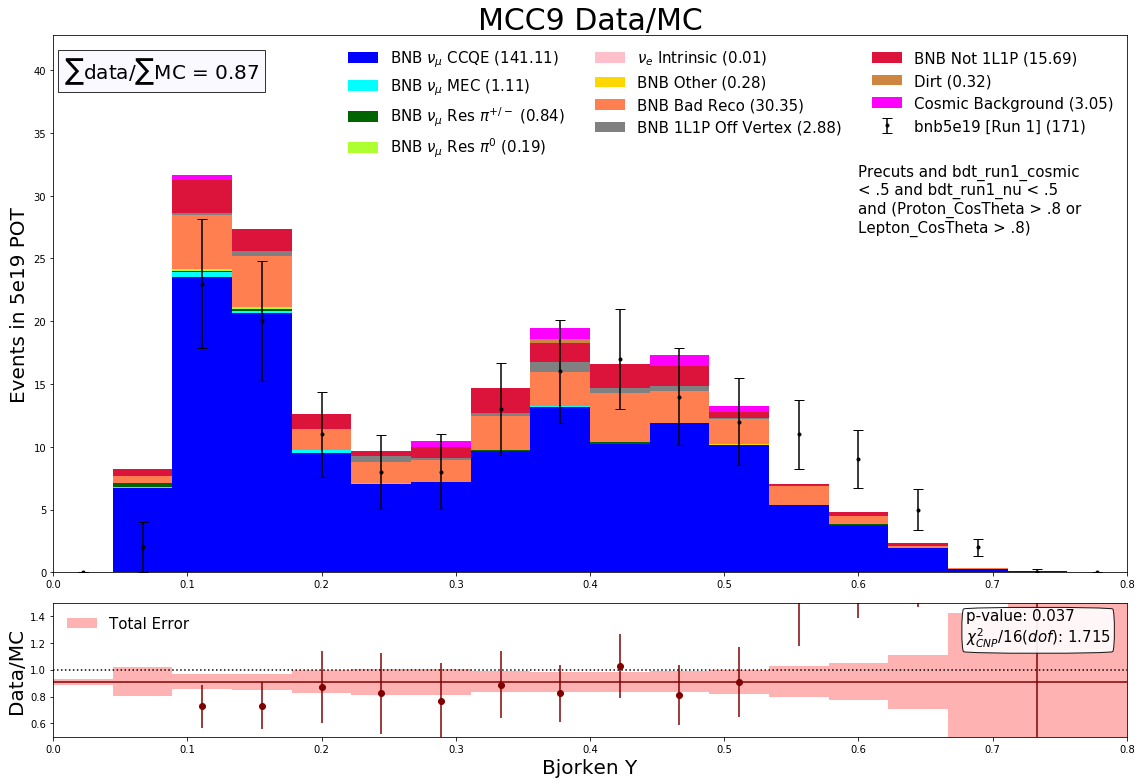

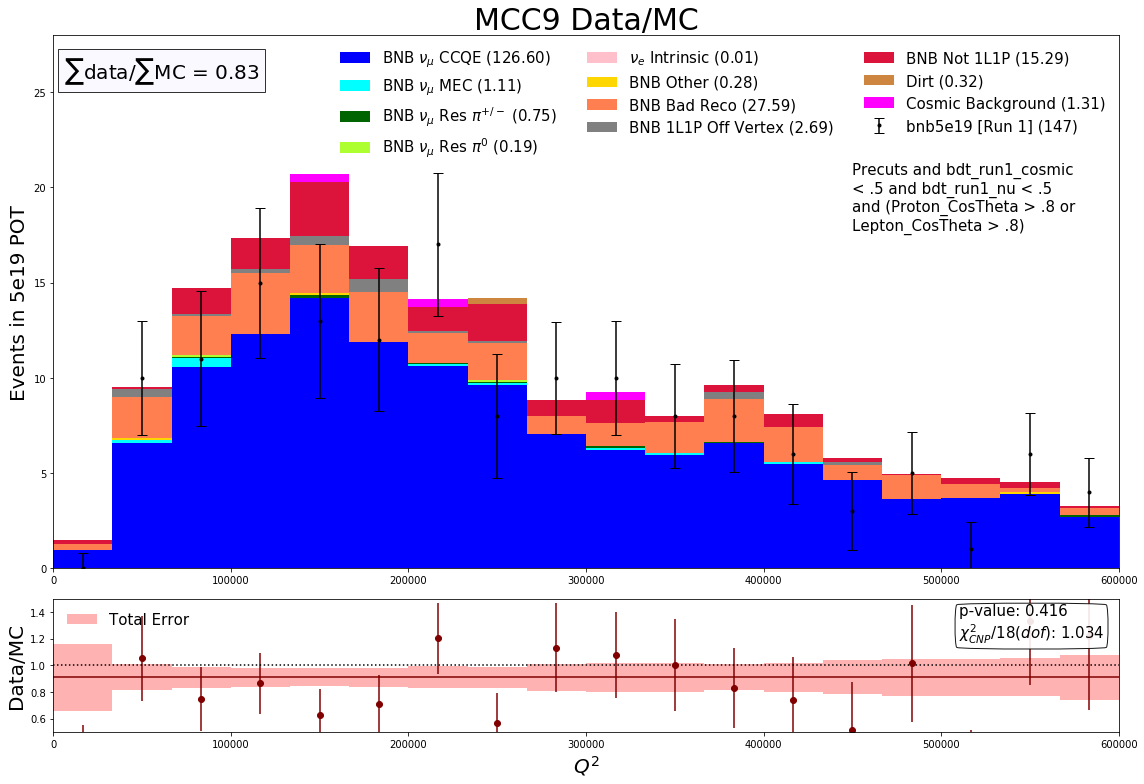

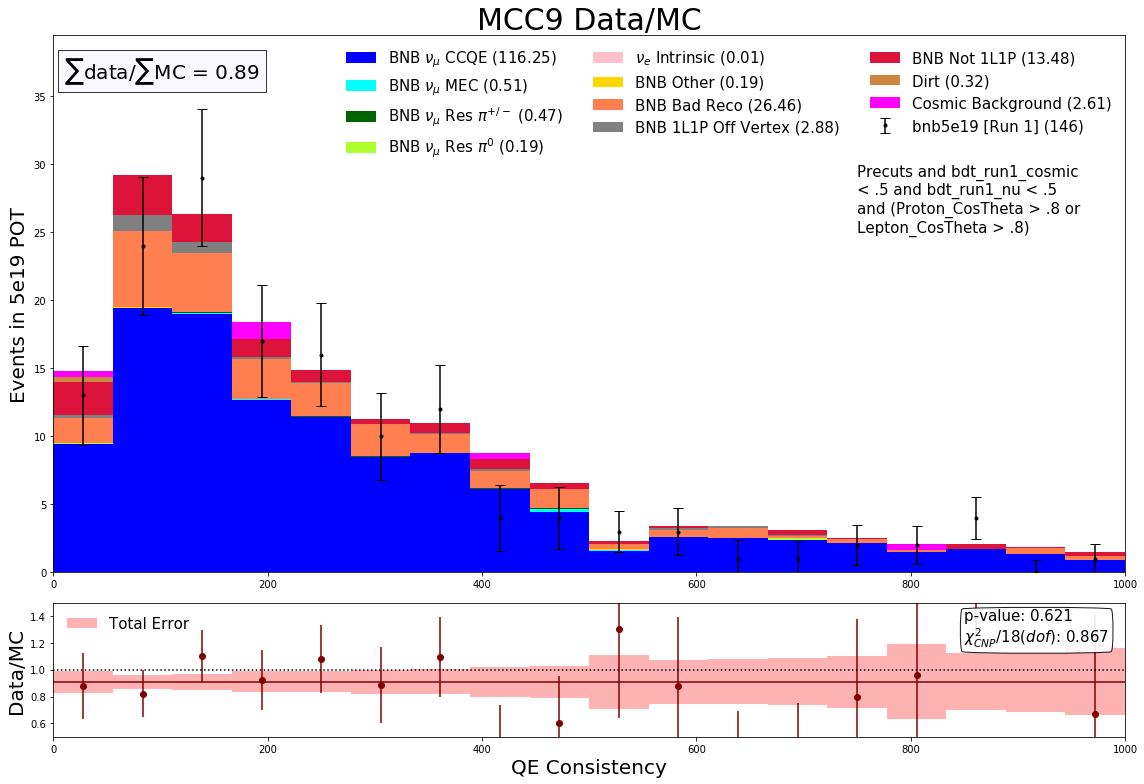

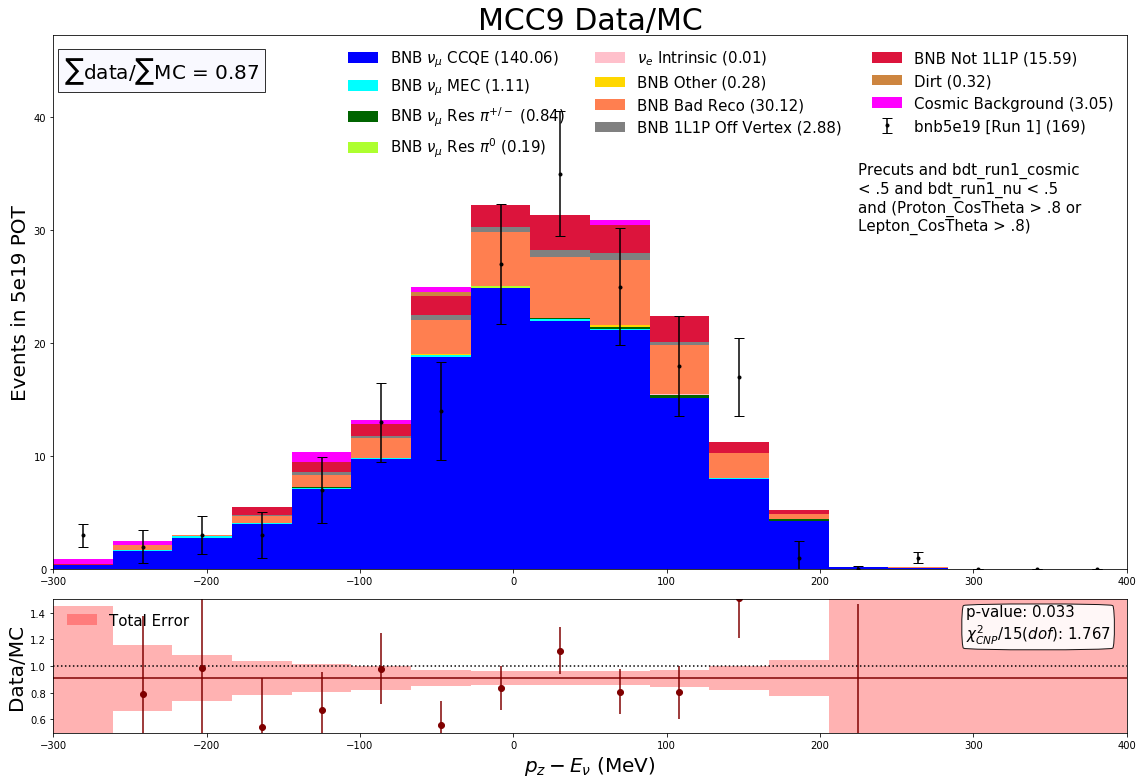

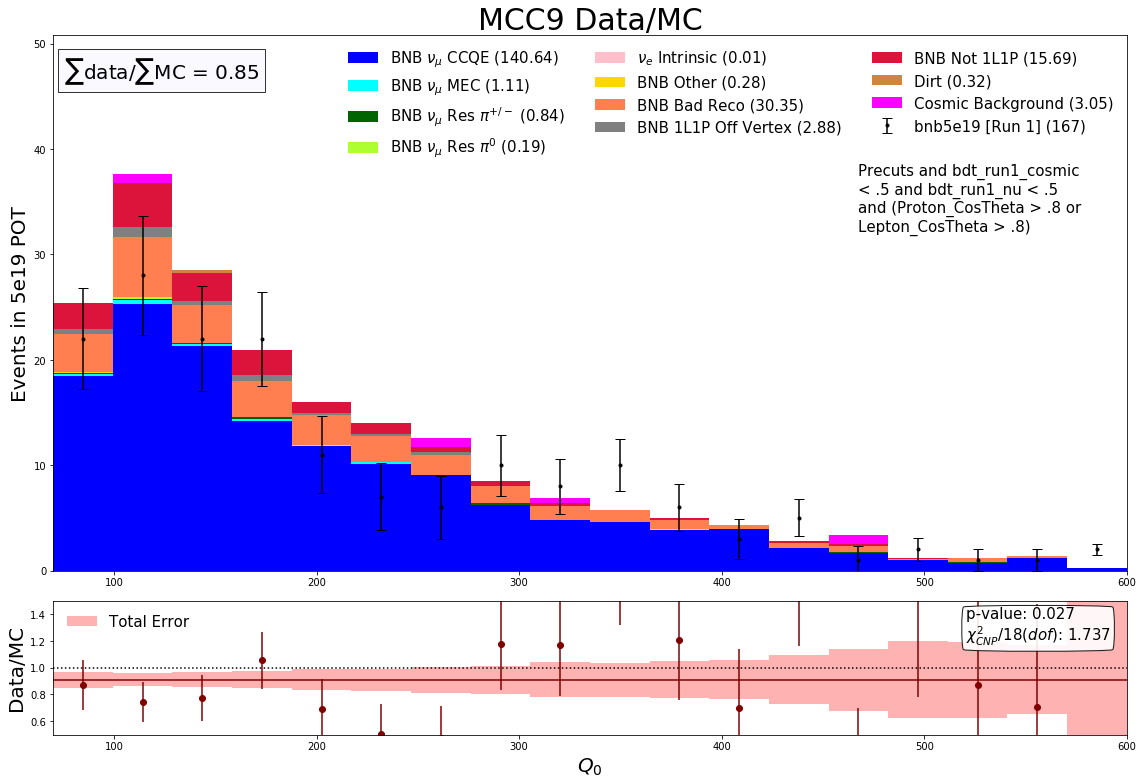

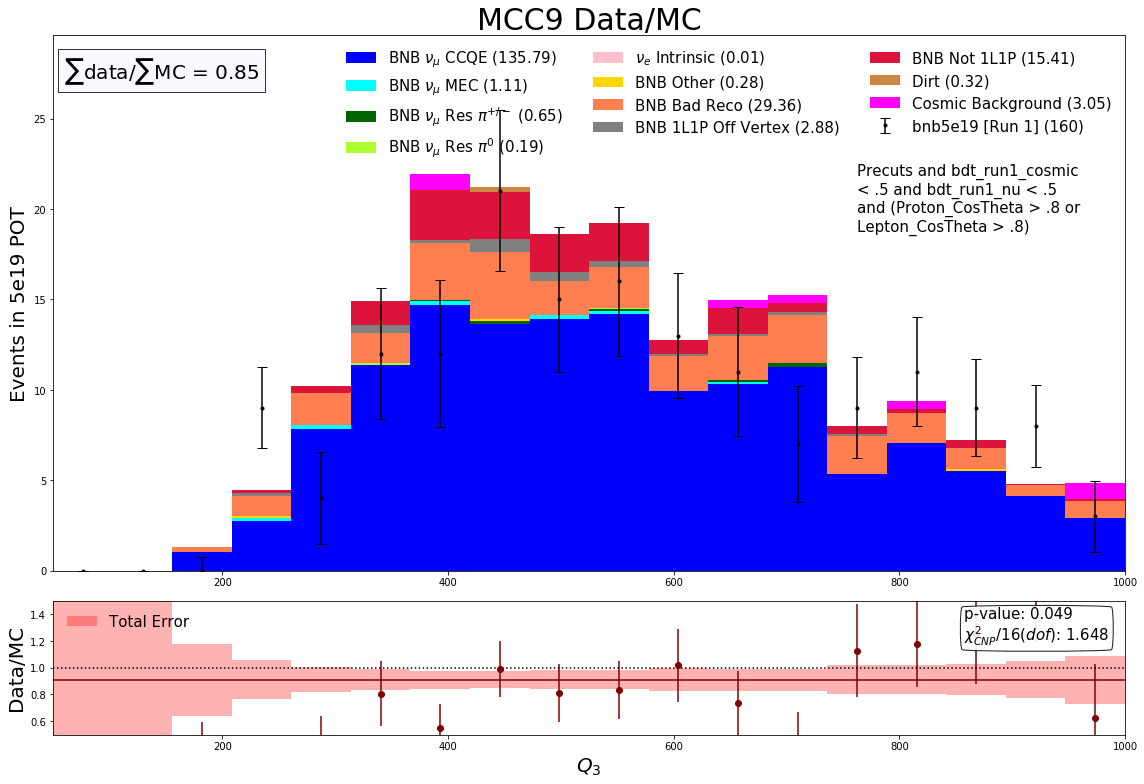

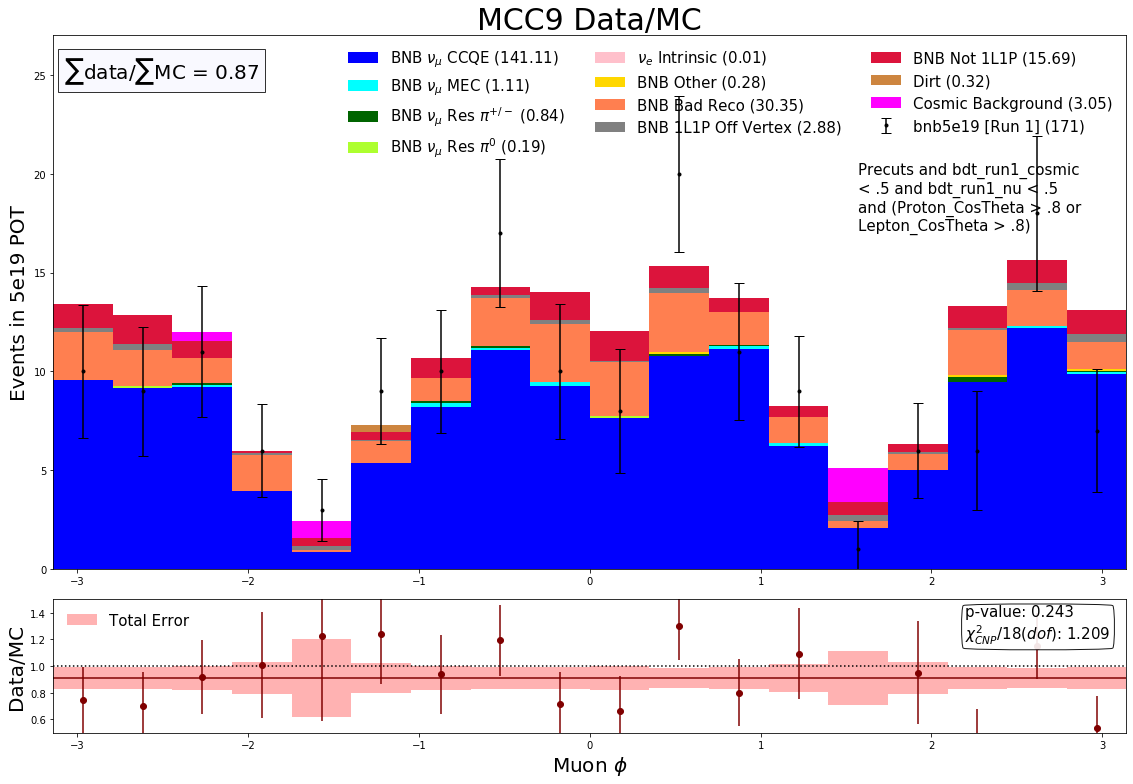

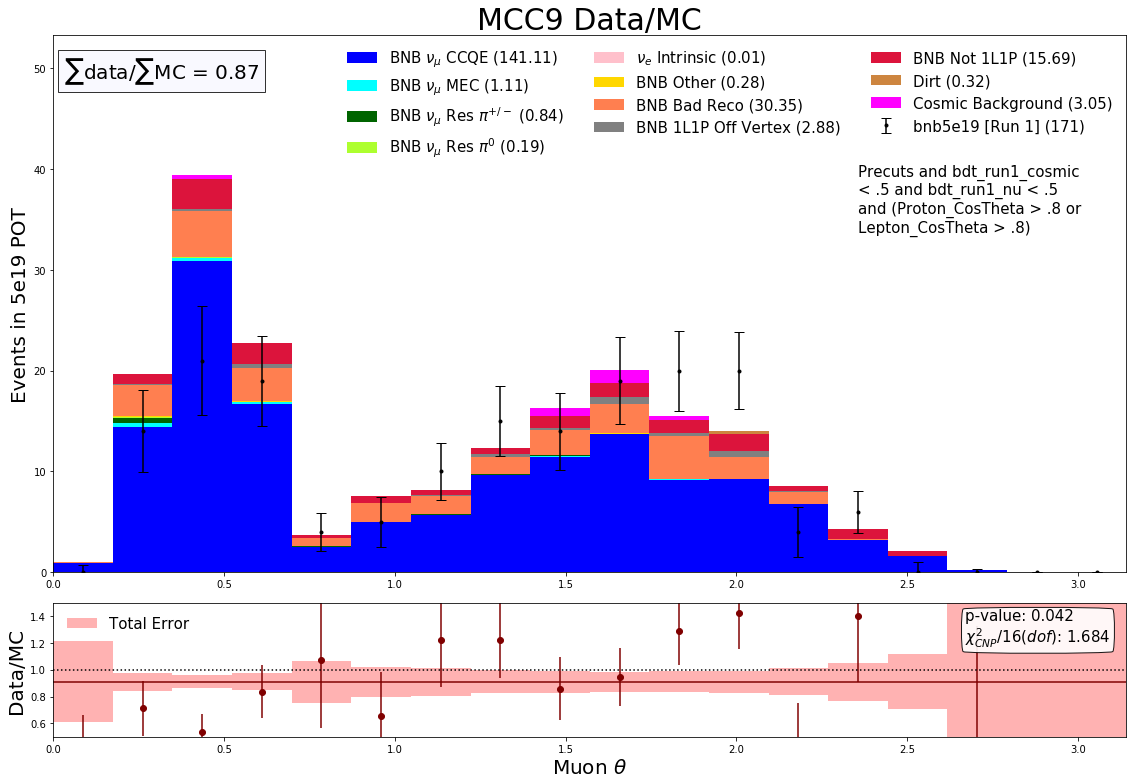

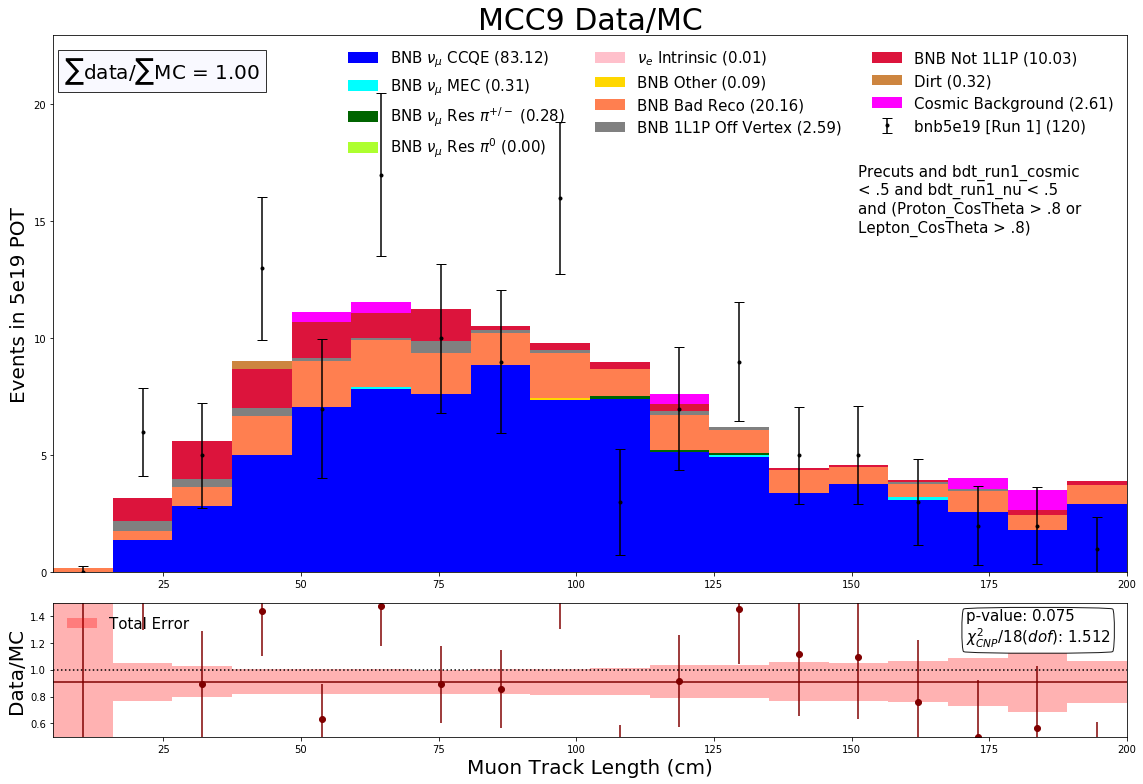

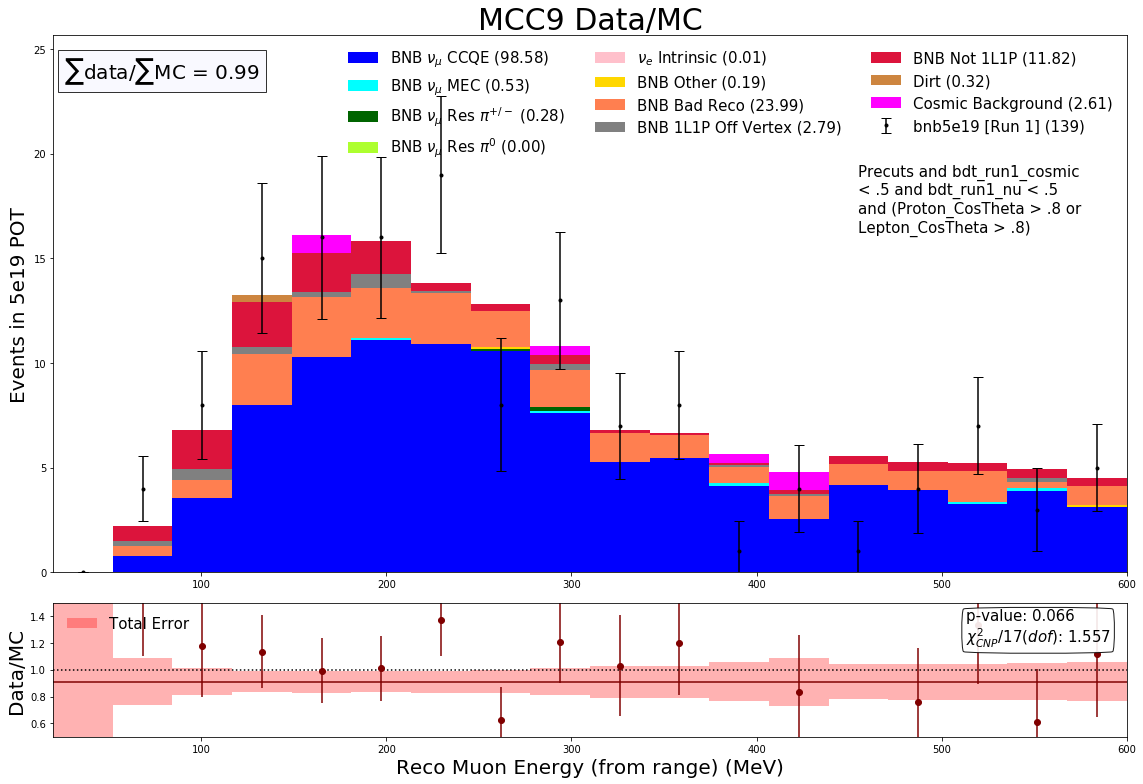

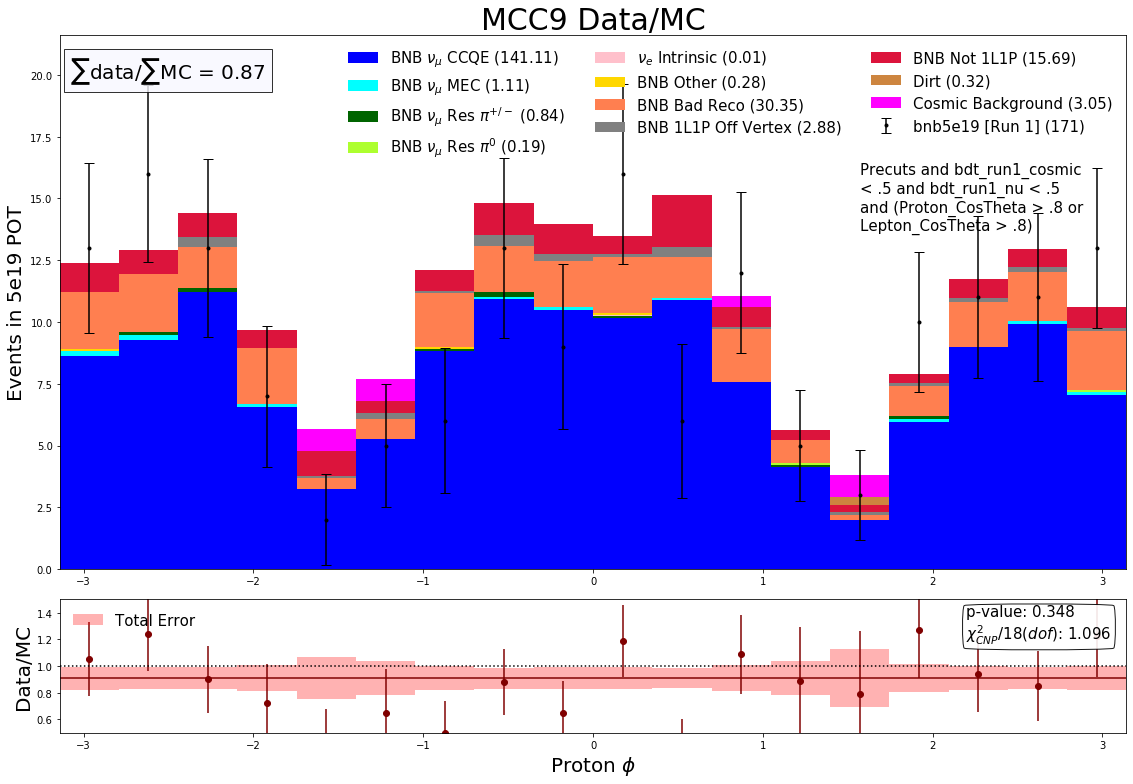

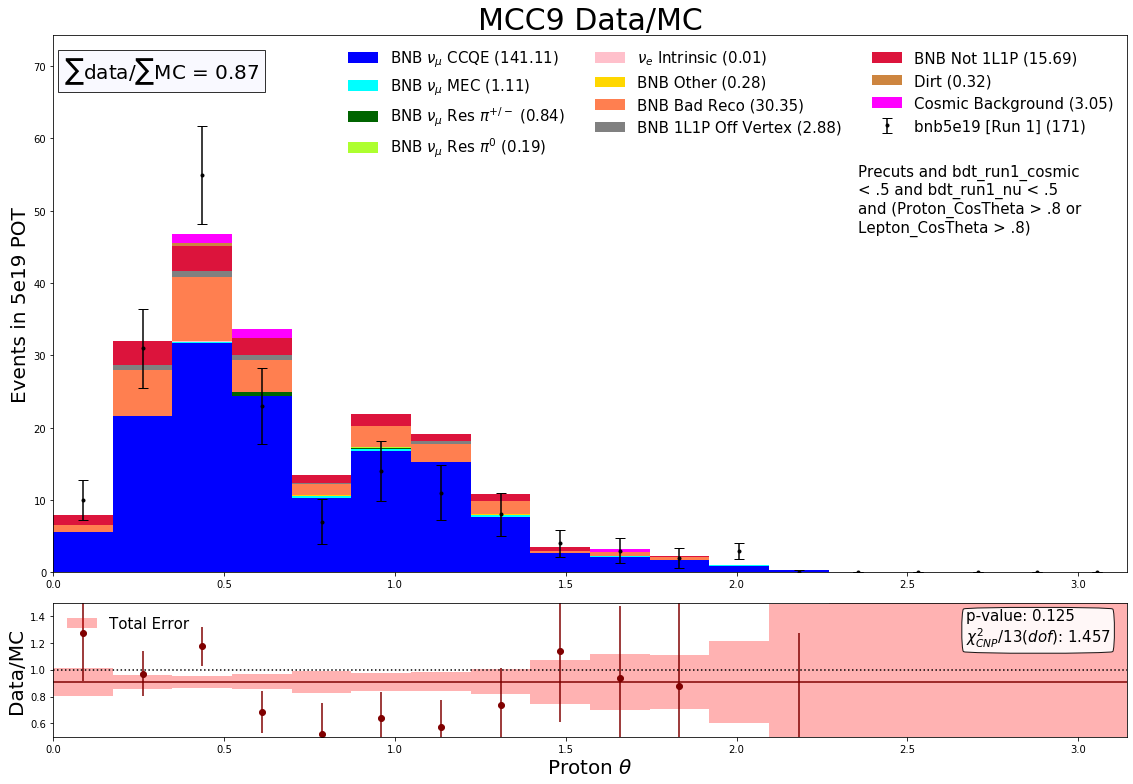

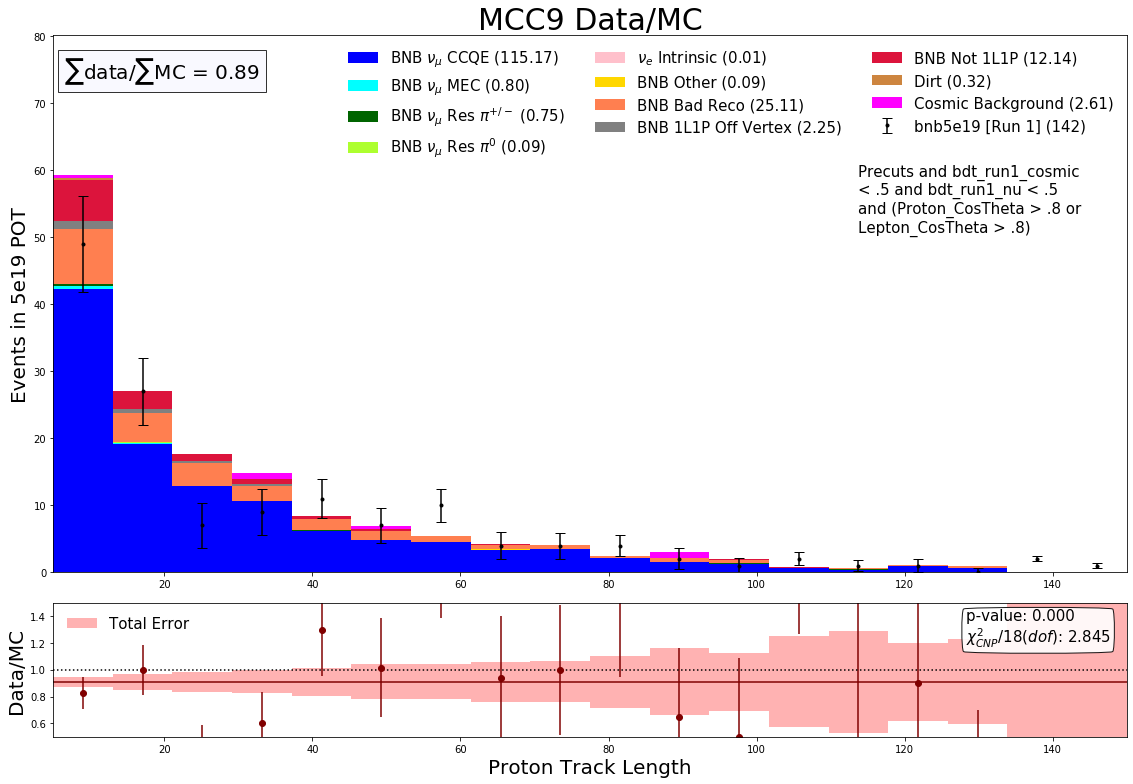

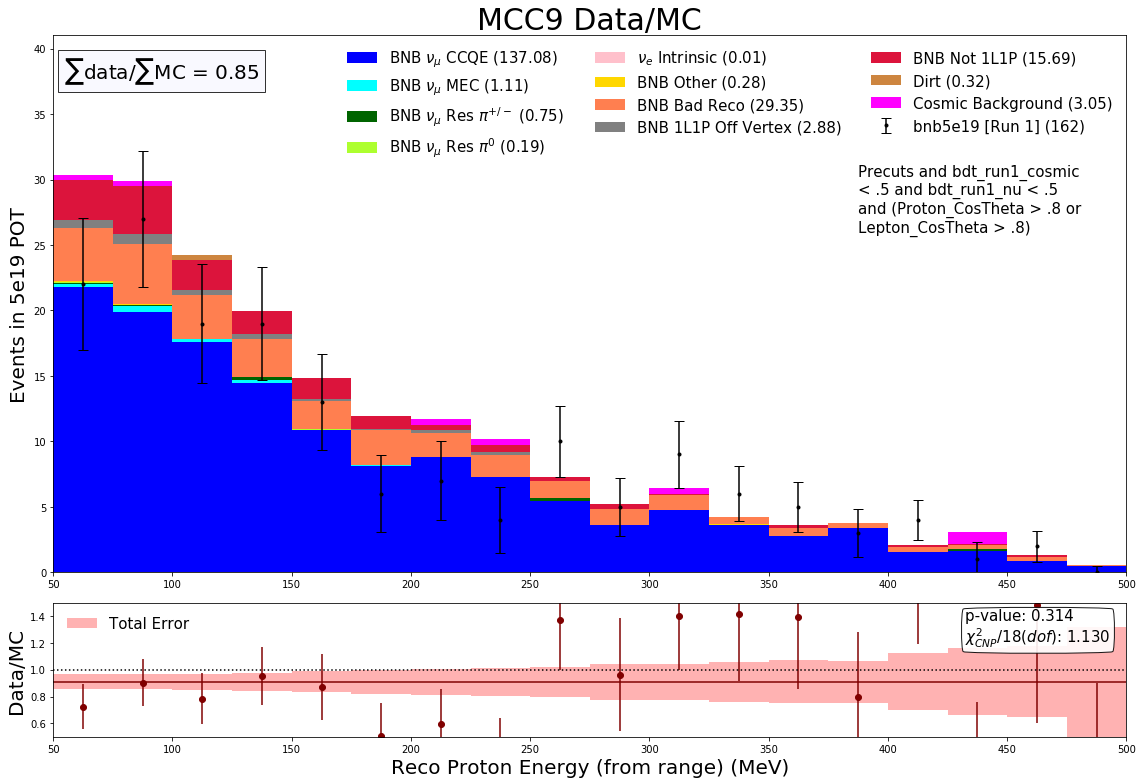

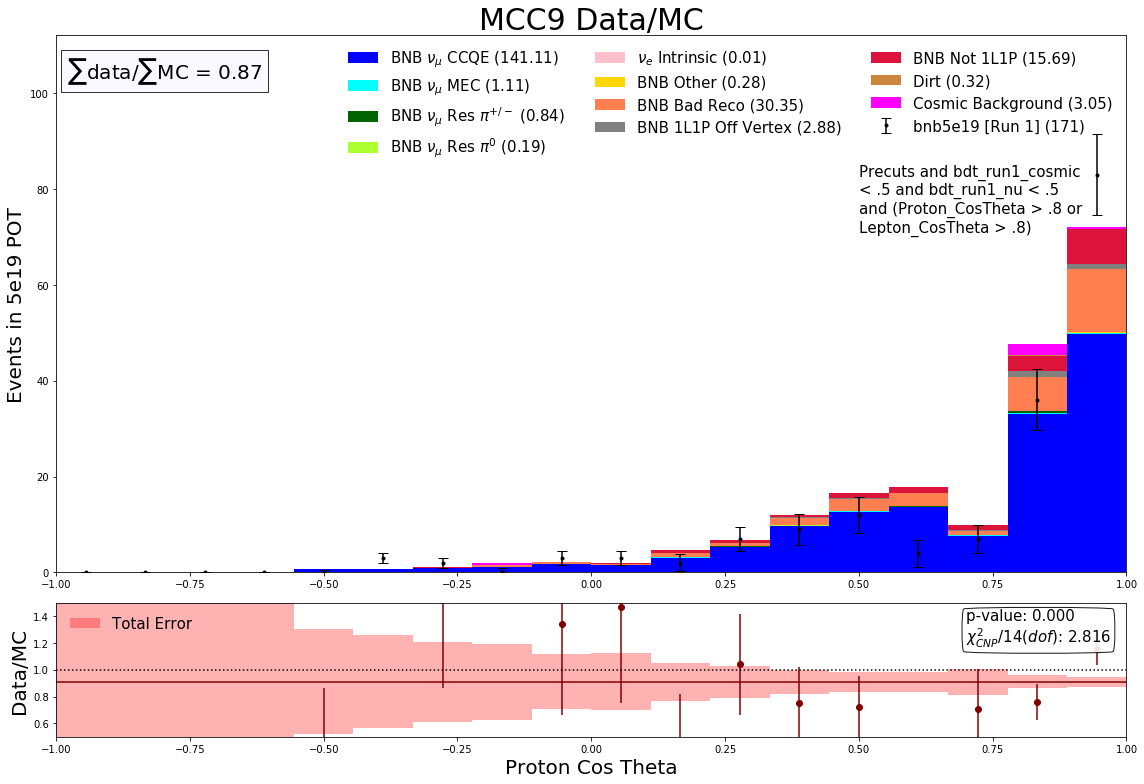

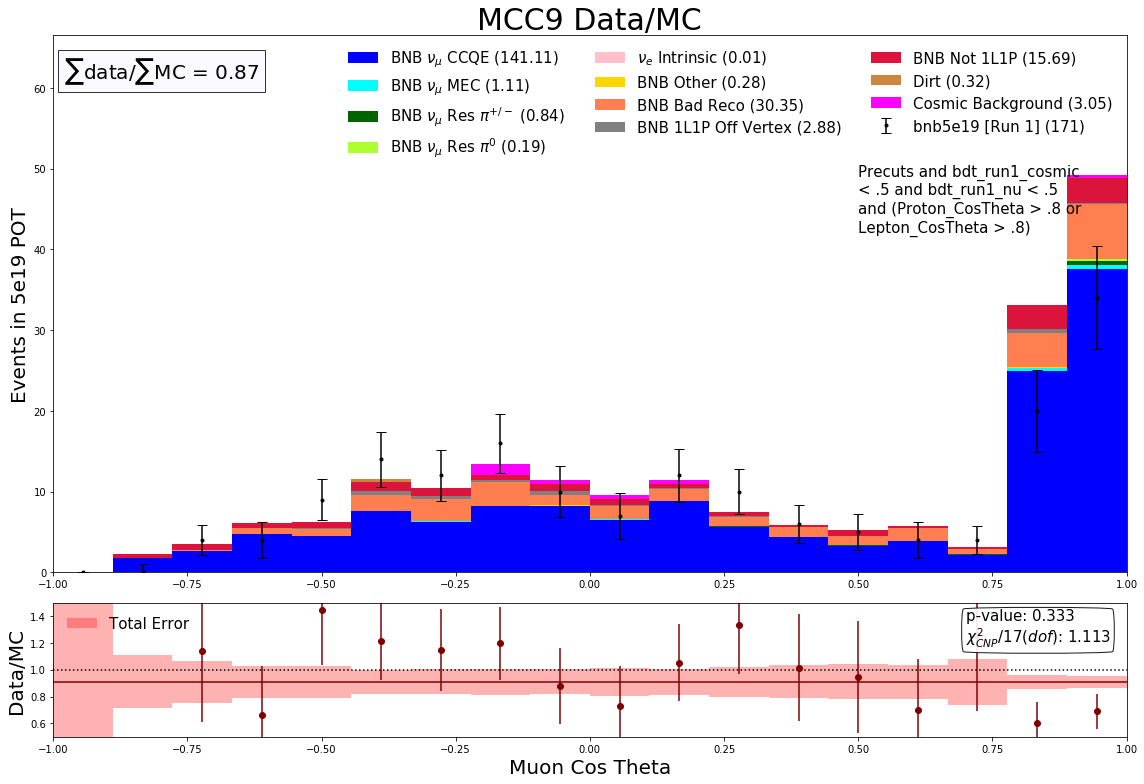

In [123]:
# Make big list of variables with their accompanying ranges so we can just dump a buttload of plots
varlistSel = []
covfolder = 'CovMatrices_May14/nogevcut'

varlistSel.append(distVar('Xreco',(15,241.25),'Reco Vertex X','../data/'+covfolder+'/covar_postsel__x_reco.txt'))
varlistSel.append(distVar('Yreco',(-101.5,101.5),'Reco Vertex Y','../data/'+covfolder+'/covar_postsel__y_reco.txt'))
varlistSel.append(distVar('Zreco',(15,1021.8),'Reco Vertex Z','../data/'+covfolder+'/covar_postsel__z_reco.txt'))
varlistSel.append(distVar('OpenAng',(.6,2.8),'Opening Angle (rads)','../data/'+covfolder+'/covar_postsel__openang_reco.txt'))
varlistSel.append(distVar('Thetas',(0,2*np.pi),r'Sum of Thetas ($\theta_{p} + \theta_{\mu}$) (rads)','../data/'+covfolder+'/covar_postsel__sum_thetas_reco.txt'))
varlistSel.append(distVar('Phis',(0,2*np.pi),r'Sum of Phis ($\phi_{p} + \phi_{\mu}$)  (rads)','../data/'+covfolder+'/covar_postsel__sum_phis_reco.txt'))
varlistSel.append(distVar('ChargeNearTrunk',(0,800),'ADC Charge within 5cm of Reco Vertex','../data/'+covfolder+'/covar_postsel__charge_near_trunk_reco.txt'))
varlistSel.append(distVar('Enu_1m1p',(300,1200),'Reconstructed Neutrino Energy (MeV)','../data/'+covfolder+'/covar_postsel__nu_energy_reco.txt'))
varlistSel.append(distVar('PhiT_1m1p',(0,1),r'$\phi_T$','../data/'+covfolder+'/covar_postsel__phiT_reco.txt'))
varlistSel.append(distVar('AlphaT_1m1p',(0,np.pi),r'$\alpha_T$','../data/'+covfolder+'/covar_postsel__alphaT_reco.txt'))
varlistSel.append(distVar('PT_1m1p',(0,400),r'$p_T$','../data/'+covfolder+'/covar_postsel__pT_reco.txt'))
varlistSel.append(distVar('PTRat_1m1p',(0,.4),r'$p_T/|p|$','../data/'+covfolder+'/covar_postsel__pT_ratio_reco.txt'))
varlistSel.append(distVar('BjX_1m1p',(0,2),'Bjorken X','../data/'+covfolder+'/covar_postsel__Bjx_reco.txt'))
varlistSel.append(distVar('BjY_1m1p',(0,.8),'Bjorken Y','../data/'+covfolder+'/covar_postsel__Bjy_reco.txt'))
varlistSel.append(distVar('Q2_1m1p',(0,6e5),r'$Q^2$','../data/'+covfolder+'/covar_postsel__Q2_reco.txt'))
varlistSel.append(distVar('Sph_1m1p',(0,1000),'QE Consistency','../data/'+covfolder+'/covar_postsel__sph_reco.txt'))
varlistSel.append(distVar('PzEnu_1m1p',(-300,400),r'$p_z - E_\nu$ (MeV)'))
varlistSel.append(distVar('Q0_1m1p',(70,600),r'$Q_0$','../data/'+covfolder+'/covar_postsel__Q0_reco.txt'))
varlistSel.append(distVar('Q3_1m1p',(50,1000),r'$Q_3$','../data/'+covfolder+'/covar_postsel__Q3_reco.txt'))
varlistSel.append(distVar('Lepton_PhiReco',(-np.pi,np.pi),r'Muon $\phi$','../data/'+covfolder+'/covar_postsel__lepton_phi_reco.txt'))
varlistSel.append(distVar('Lepton_ThetaReco',(0,np.pi),r'Muon $\theta$','../data/'+covfolder+'/covar_postsel__lepton_theta_reco.txt'))
varlistSel.append(distVar('Lepton_TrackLength',(5,200),'Muon Track Length (cm)','../data/'+covfolder+'/covar_postsel__lepton_length_reco.txt'))
varlistSel.append(distVar('Muon_Edep',(20,600),'Reco Muon Energy (from range) (MeV)','../data/'+covfolder+'/covar_postsel__lepton_KE_reco.txt'))
varlistSel.append(distVar('Proton_PhiReco',(-np.pi,np.pi),r'Proton $\phi$','../data/'+covfolder+'/covar_postsel__proton_phi_reco.txt'))
varlistSel.append(distVar('Proton_ThetaReco',(0,np.pi),r'Proton $\theta$','../data/'+covfolder+'/covar_postsel__proton_theta_reco.txt'))
varlistSel.append(distVar('Proton_TrackLength',(5,150),'Proton Track Length','../data/'+covfolder+'/covar_postsel__proton_length_reco.txt'))
varlistSel.append(distVar('Proton_Edep',(50,500),'Reco Proton Energy (from range) (MeV)','../data/'+covfolder+'/covar_postsel__proton_KE_reco.txt'))
varlistSel.append(distVar('Proton_CosTheta',(-1,1),'Proton Cos Theta','../data/'+covfolder+'/covar_postsel__proton_cos_theta_reco.txt'))
varlistSel.append(distVar('Lepton_CosTheta',(-1,1),'Muon Cos Theta','../data/'+covfolder+'/covar_postsel__lepton_cos_theta_reco.txt'))

#Big Dumpus (for selected events)
dumphole = 'forwardcut'
mybins = 18

plt.ioff()

a_pval = []
a_varname = []

if not os.path.exists(dumphole):
    os.makedirs(dumphole)

for dist in varlistSel:
    if dist.myscov == '':
        ns = .91
    else:
        ns = 1
    fig,ax0,pval = distplot_wratio(dist.myname,nbins,dist.myrange,run1Hists,run1DataHist,dist.mylabel,normshift=.91)#ns,s_cov=dist.myscov)
    ax0.annotate(s_ano_simple,xy=(.75,.6), xycoords='axes fraction',fontsize=15)
    #ax0.set_ylabel('Events in e20 POT',fontsize=20)
    plt.savefig(dumphole+'/'+dist.myname+'.png')
    a_pval.append(pval)
    a_varname.append(dist.myname)